# Candlestick Analysis with Clustering and Reinforcement Learning

Esse projeto combina a clusterizacao de candles de graficos candlestick com o aprendizado por reforço.
a clusterizacao, é uma forma de agrupar e tals e o algoritmo que eu usei foi o kmeans. o numero de clusters usado foi seguindo o projeto anterior. as bibliotecas utilizadas foram: pandas, numpy, matplotlib, sklearn, mplfinance, itertools, random. Para comecar foi feito uma etapa de preprocessamento, onde eu a principio importei a base de dados, inverti ela para ficar no tempo certo, selecionei as colunas de interesse e adicionei outras features que seriam importantes no decorrer do projeto. alem disso ajustei um erro na base de dados que o python estava interpretando errado. feito isso, parti para a clusterização. utilizei ao todo 175 clusters, o mesmo do projeto anterior, esse numero vem de um conjunto feito entre o numero de clusters do corpo e das sombras, sendo 7 clusters para o tamanho do corpo e 5 para cada uma das sombras. Por fim, foi aplicado o aprendizado por reforço, onde o estado era os clusters, as acoes eram: comprar, vender e segurar, e a recompesa era a subtração do preço de fechamento do estado seguinte pelo estado atual. No aprendizado por reforco usei os seguintes hiperparametros:
alpha = 0.1      # taxa de aprendizado
gamma = 0.95     # fator de desconto
epsilon = 0.1    # exploração
n_episodes = 2000
Utilizamos um valor inicial de dinheiro igual a 10000 e 0 ações, ao longo do treinamento o usuario ia usando o dinheiro para comprar ações e assim interagindo com o mercado a cada amostrando tendo que tomar uma decisao baseada no estado atual, comprar vender ou apenas segurar, o algoritmo que eu utiizei foi o q-learning, um algoritmo simples de atualizações da tabela q, depois de treinada podemos observar a politica otima adotada pelo agente. 
durante o projeto eu fui salvando em arquivos csv o andamento do projeto, por fim fiz alguns testes para ver se o algoritmo estava funcionando

From preprocessing to intelligent decision-making, this pipeline handles the entire candle data analysis flow with AI-driven insights.

---

## Project Overview

- **Preprocessing** candlestick data  
- **Clustering** using KMeans (body, lower and upper shadow)  
- **Visualization** of clusters and candlestick groups  
- **Reinforcement Learning agent (Q-Learning)** trained to act on clustered patterns  
- **Visualization of agent’s actions** over time  

In [150]:
# Importação de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import Normalizer
import mplfinance as mpf
import itertools
import random

## Preprocessing

In [ ]:
def load_path(filepath, index_col='Date', parse_dates=True):
    return pd.read_csv(filepath, index_col=index_col, parse_dates=parse_dates)

def inverter(data):
    return data[::-1]

def select_columns(data, columns=['Open', 'Close', 'High', 'Low']):
    return data[columns].dropna()

def standardize_values(data):
    for col in data.columns:
        data.loc[data[col] < 1000, col] *= 1000
    return data


def add_features(df):
    """
    Compute both absolute and ratio-based features for candle clustering.
    
    Returns a DataFrame with:
    - body, upper_shadow, lower_shadow
    - total_length
    - body_ratio, upper_shadow_ratio, lower_shadow_ratio
    - log_total_length (for scale awareness)
    """
    df = df.copy()

    # Absolute values
    df['body'] = (df['Close'] - df['Open']).abs()
    df['upper_shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']
    df['total_length'] = df['High'] - df['Low']
    df['total_length'] = df['total_length'].replace(0, 1e-8)  # avoid division by zero

    # Ratios
    df['body_ratio'] = df['body'] / df['total_length']
    df['upper_shadow_ratio'] = df['upper_shadow'] / df['total_length']
    df['lower_shadow_ratio'] = df['lower_shadow'] / df['total_length']

    # Add logarithmic size scale to help clustering differentiate sizes
    df['log_total_length'] = np.log(df['total_length'])

    return df



data = load_path('../data/dados.csv')
data = inverter(data)
data = select_columns(data)
data = standardize_values(data)
data = add_features(data)

normalizer = Normalizer()
normalized_data = pd.DataFrame(normalizer.fit_transform(data), columns=data.columns, index=data.index)
#normalized_data = normalized_data[(normalized_data['upper_shadow'] < 0.0003) & (normalized_data['lower_shadow'] < 0.0003)]

/tmp/ipykernel_31570/3363098756.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(filepath, index_col=index_col, parse_dates=parse_dates)


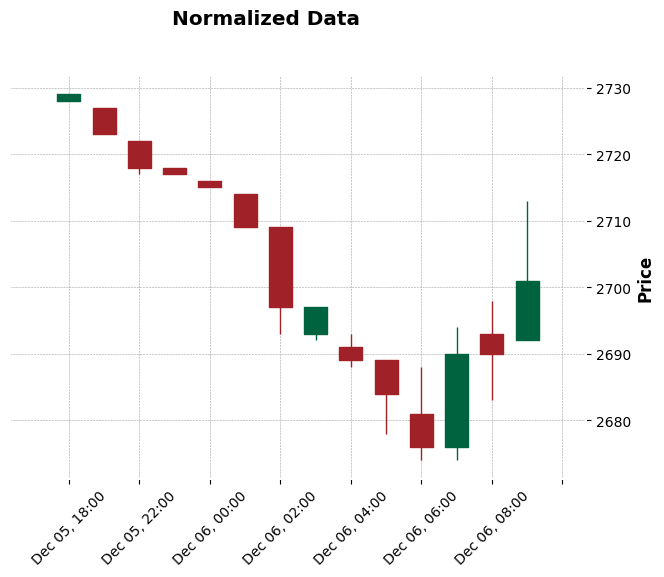

In [152]:
mpf.plot(data.iloc[:14], type='candle', style='charles', title='Normalized Data', ylabel='Price', volume=False, show_nontrading=False)

In [153]:
data

,Open,Close,High,Low,body,upper_shadow,lower_shadow,total_length,body_ratio,upper_shadow_ratio,lower_shadow_ratio,log_total_length
Date,,,,,,,,,,,,
2024-12-05 18:00:00,2728.0,2729.0,2729.0,2728.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000
2024-12-05 19:00:00,2727.0,2723.0,2727.0,2723.0,4.0,0.0,0.0,4.0,1.000000,0.000000,0.000000,1.386294
2024-12-05 22:00:00,2722.0,2718.0,2722.0,2717.0,4.0,0.0,1.0,5.0,0.800000,0.000000,0.200000,1.609438
2024-12-05 23:00:00,2718.0,2717.0,2718.0,2717.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000
2024-12-06 00:00:00,2716.0,2715.0,2716.0,2715.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 04:00:00,3910.0,3922.0,3930.0,3910.0,12.0,8.0,0.0,20.0,0.600000,0.400000,0.000000,2.995732
2025-03-26 05:00:00,3922.0,3894.0,3922.0,3890.0,28.0,0.0,4.0,32.0,0.875000,0.000000,0.125000,3.465736
2025-03-26 06:00:00,3891.0,3886.0,3894.0,3868.0,5.0,3.0,18.0,26.0,0.192308,0.115385,0.692308,3.258097


## KMeans Clustering

In [154]:
df = data.copy()

features = df[['body_ratio', 'upper_shadow_ratio', 'lower_shadow_ratio', 'log_total_length']]

df['cluster'] = KMeans(n_clusters=130, random_state=42).fit_predict(features)

In [155]:
df.head(14)

,Open,Close,High,Low,body,upper_shadow,lower_shadow,total_length,body_ratio,upper_shadow_ratio,lower_shadow_ratio,log_total_length,cluster
Date,,,,,,,,,,,,,
2024-12-05 18:00:00,2728.0,2729.0,2729.0,2728.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,12
2024-12-05 19:00:00,2727.0,2723.0,2727.0,2723.0,4.0,0.0,0.0,4.0,1.000000,0.000000,0.000000,1.386294,85
2024-12-05 22:00:00,2722.0,2718.0,2722.0,2717.0,4.0,0.0,1.0,5.0,0.800000,0.000000,0.200000,1.609438,128
2024-12-05 23:00:00,2718.0,2717.0,2718.0,2717.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,12
2024-12-06 00:00:00,2716.0,2715.0,2716.0,2715.0,1.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,0.000000,12
2024-12-06 01:00:00,2714.0,2709.0,2714.0,2709.0,5.0,0.0,0.0,5.0,1.000000,0.000000,0.000000,1.609438,116
2024-12-06 02:00:00,2709.0,2697.0,2709.0,2693.0,12.0,0.0,4.0,16.0,0.750000,0.000000,0.250000,2.772589,104
2024-12-06 03:00:00,2693.0,2697.0,2697.0,2692.0,4.0,0.0,1.0,5.0,0.800000,0.000000,0.200000,1.609438,128
2024-12-06 04:00:00,2691.0,2689.0,2693.0,2688.0,2.0,2.0,1.0,5.0,0.400000,0.400000,0.200000,1.609438,35


In [156]:
def fit_individual_clusters(data, n_body_clusters, n_lower_shadow_clusters, n_upper_shadow_clusters):
    models = {
        'body_ratio': KMeans(n_clusters=n_body_clusters, random_state=42),
        'lower_shadow_ratio': KMeans(n_clusters=n_lower_shadow_clusters, random_state=42),
        'upper_shadow_ratio': KMeans(n_clusters=n_upper_shadow_clusters, random_state=42)
    }

    data['body_cluster'] = models['body_ratio'].fit_predict(data[['body_ratio']])
    data['lower_shadow_cluster'] = models['lower_shadow_ratio'].fit_predict(data[['lower_shadow_ratio']])
    data['upper_shadow_cluster'] = models['upper_shadow_ratio'].fit_predict(data[['upper_shadow_ratio']])

    return data




def assign_combined_clusters(data):
    # Determine the maximum cluster values
    n_body_clusters = data['body_cluster'].max() + 1
    n_lower_shadow_clusters = data['lower_shadow_cluster'].max() + 1
    n_upper_shadow_clusters = data['upper_shadow_cluster'].max() + 1

    # Generate all possible combinations
    all_combinations = list(itertools.product(range(0, n_body_clusters), 
                                              range(0, n_lower_shadow_clusters), 
                                              range(0, n_upper_shadow_clusters)))

    # Create a DataFrame with all combinations
    unique_combinations = pd.DataFrame(all_combinations, 
                                       columns=['body_cluster', 'lower_shadow_cluster', 'upper_shadow_cluster'])

    # Assign a unique ID to each combination
    unique_combinations['combined_cluster'] = range(1, len(unique_combinations) + 1)

    # Create a mapping dictionary
    combination_mapping = {
        (row['body_cluster'], row['lower_shadow_cluster'], row['upper_shadow_cluster']): row['combined_cluster']
        for _, row in unique_combinations.iterrows()
    }

    # Map the combined clusters to the original DataFrame
    data['cluster'] = data.apply(
        lambda row: combination_mapping[
            (row['body_cluster'], row['lower_shadow_cluster'], row['upper_shadow_cluster'])
        ],
        axis=1
    )

    return data

def reorder_clusters(data, feature, cluster_col):
    cluster_means = data.groupby(cluster_col)[feature].mean().sort_values()
    mapping = {old: new for new, old in enumerate(cluster_means.index)}
    data[cluster_col] = data[cluster_col].map(mapping)
    return data

In [157]:
n_body_clusters = 7
n_lower_shadow_clusters = 5
n_upper_shadow_clusters = 5

normalized_data = fit_individual_clusters(normalized_data, n_body_clusters, n_lower_shadow_clusters, n_upper_shadow_clusters)
data = fit_individual_clusters(data, n_body_clusters, n_lower_shadow_clusters, n_upper_shadow_clusters)

normalized_data = reorder_clusters(normalized_data, 'body', 'body_cluster')
normalized_data = reorder_clusters(normalized_data, 'lower_shadow', 'lower_shadow_cluster')
normalized_data = reorder_clusters(normalized_data, 'upper_shadow', 'upper_shadow_cluster')

data = reorder_clusters(data, 'body_ratio', 'body_cluster')
data = reorder_clusters(data, 'lower_shadow_ratio', 'lower_shadow_cluster')
data = reorder_clusters(data, 'upper_shadow_ratio', 'upper_shadow_cluster')

normalized_data = assign_combined_clusters(normalized_data)
data = assign_combined_clusters(data)

In [158]:
# Salvei o data sem normalização para aplicar o reinforcement learning

data.to_csv('../outputs/data_with_clusters.csv', index=True)

## Visualization cluster distributions

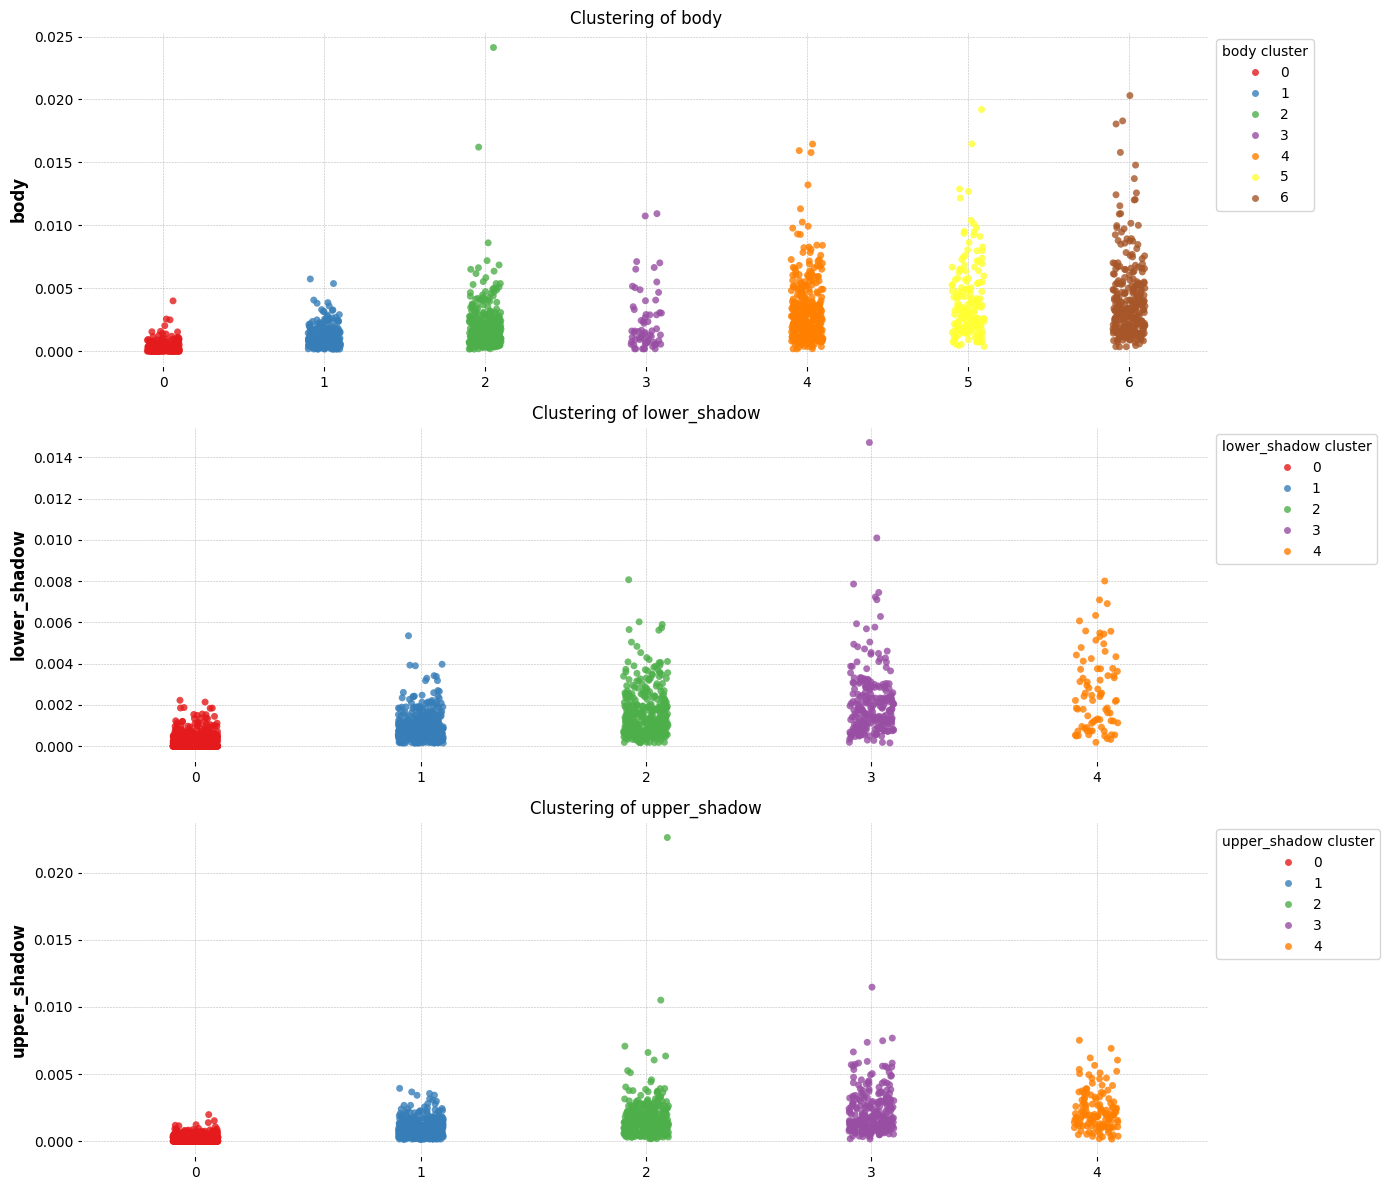

In [159]:
custom_palette = 'Set1'

def plot_cluster_distribution(data, features, figsize=(14, 12)):
    plt.figure(figsize=figsize)

    for i, feature in enumerate(features, 1):
        plt.subplot(len(features), 1, i)
        sns.stripplot(
            x=f'{feature}_cluster',
            y=feature,
            data=data,
            hue=f'{feature}_cluster',
            palette=custom_palette,
            jitter=True,
            alpha=0.8
        )
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.title(f'Clustering of {feature}')
        plt.xlabel('')
        plt.legend(title=f'{feature} cluster', bbox_to_anchor=(1, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

plot_cluster_distribution(normalized_data, features=['body', 'lower_shadow', 'upper_shadow'])

## Visualization candlestick chart with clusters

In [160]:
# Select part of the data for plotting

middle_data = data.iloc[435:500]
middle_data_normalized = normalized_data.iloc[415:425]

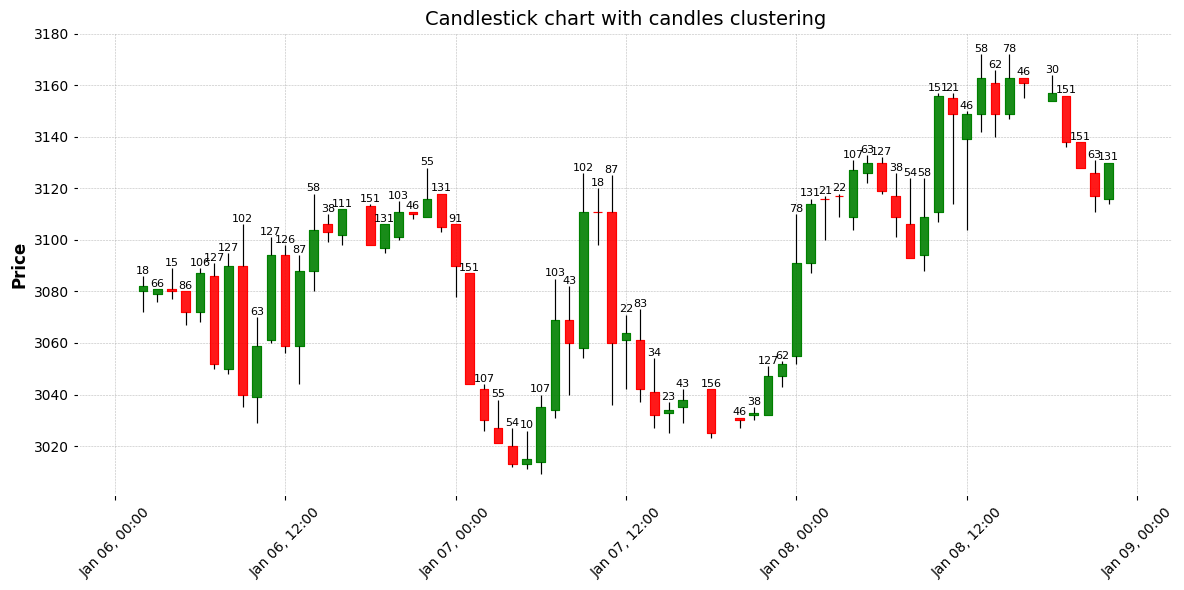

In [161]:
samples_per_cluster = [min(count, 7) for count in data.sort_values('cluster')['cluster'].value_counts().sort_index()]
cumulative_samples = list(itertools.accumulate(samples_per_cluster, initial=0))

# Configure color and graoh styles
mc = mpf.make_marketcolors(up='g', down='r', wick='black', edge='inherit')
s = mpf.make_mpf_style(marketcolors=mc)

# Plot a candlestick chart
fig, ax = plt.subplots(figsize=(12, 6))
mpf.plot(middle_data, type='candle', ax=ax, style=s, show_nontrading=True)
plt.grid(True, linestyle='--', alpha=0.7)

# Add labels for the new combined cluster
for i, row in middle_data.iterrows():
    ax.text(row.name, row['High'] + 0.1, int(row['cluster']), 
            fontsize=8, ha='center', va='bottom', color='black')

# Titles and labels
ax.set_title('Candlestick chart with candles clustering', fontsize=14)
ax.set_ylabel('Price', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## Visualization of each cluster

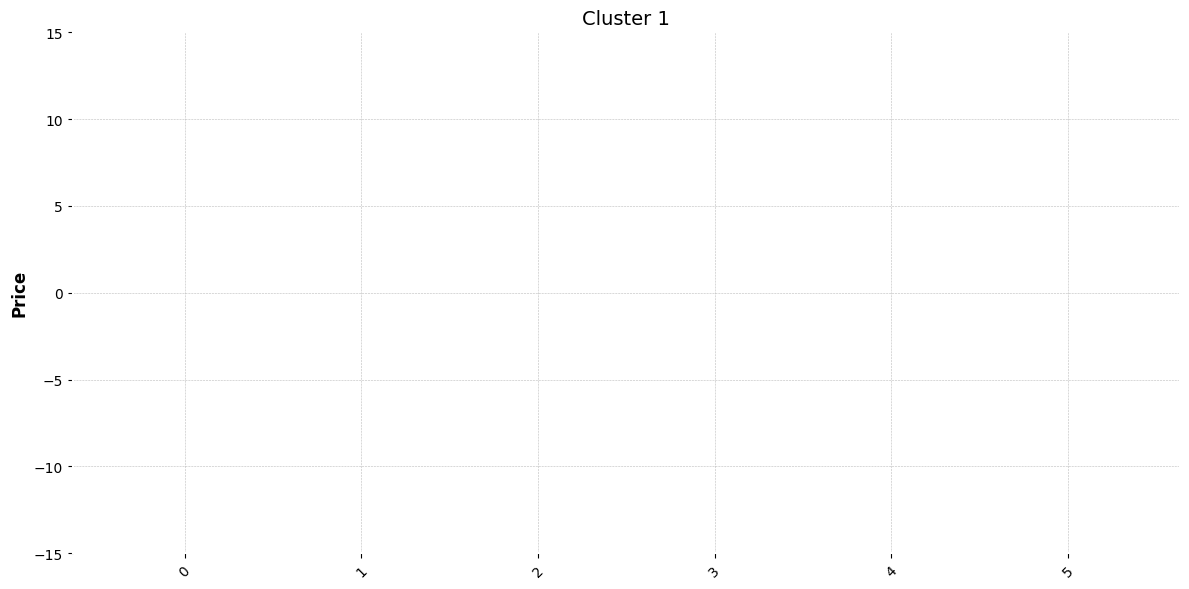

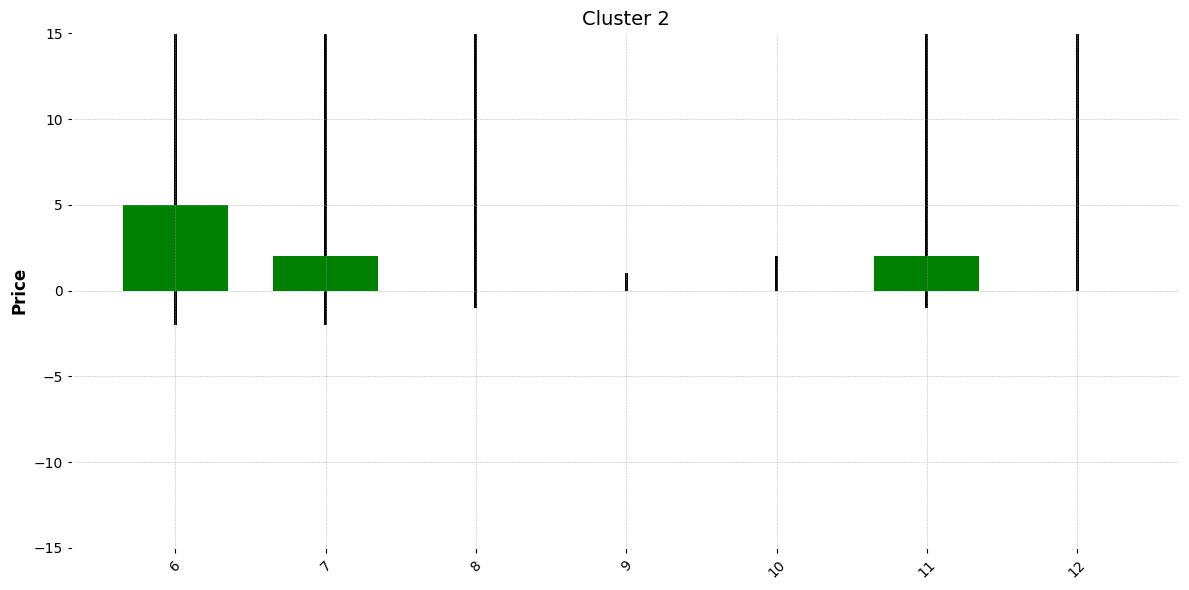

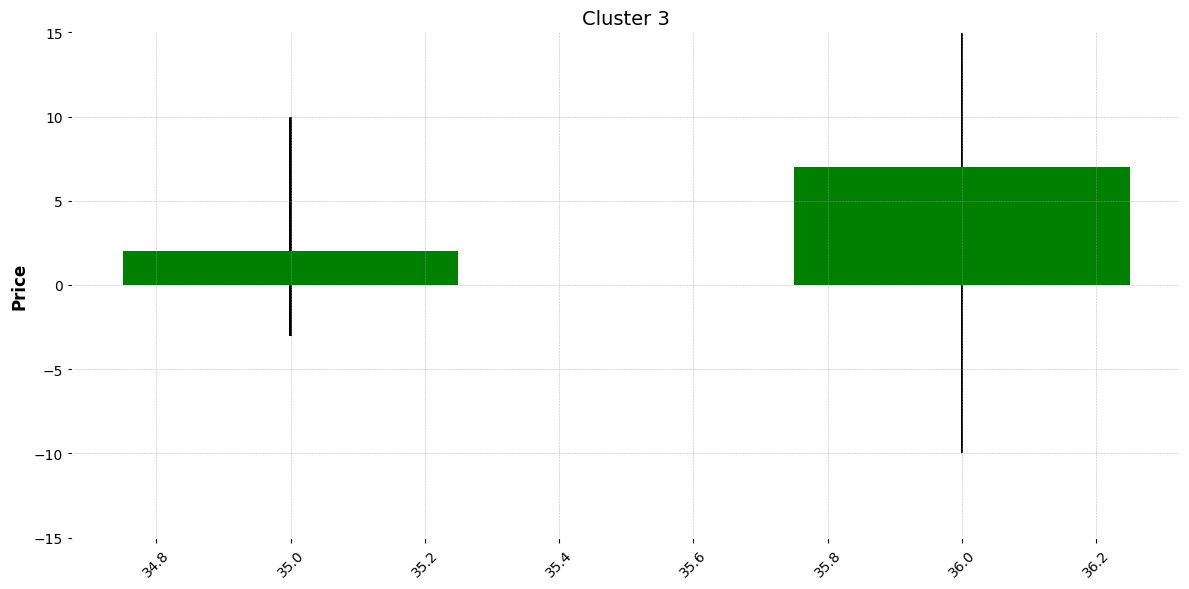

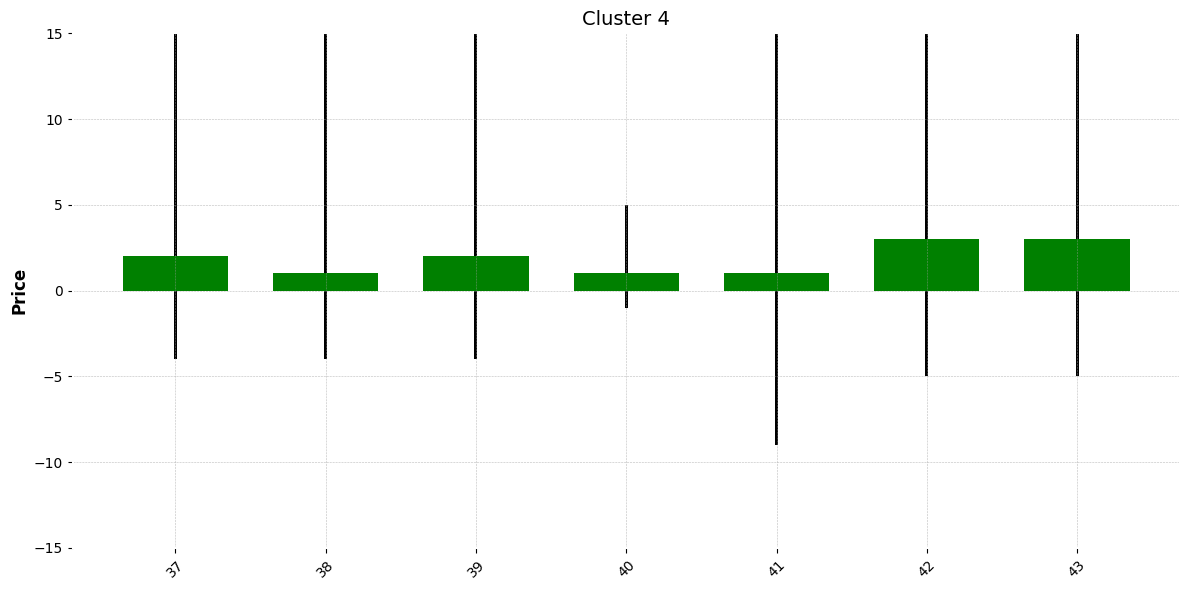

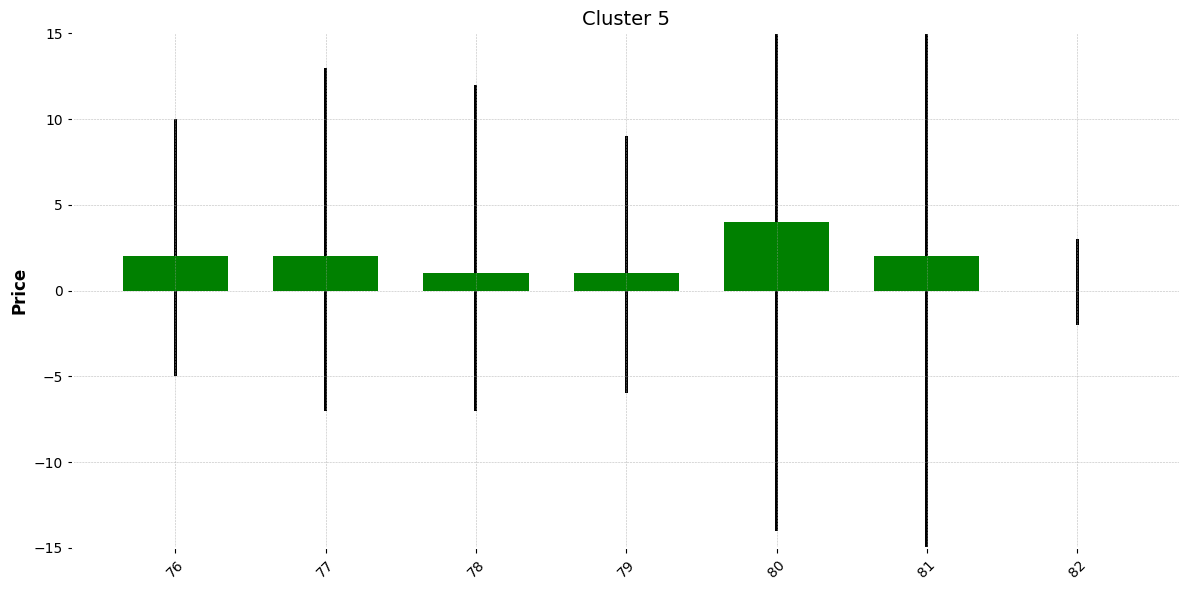

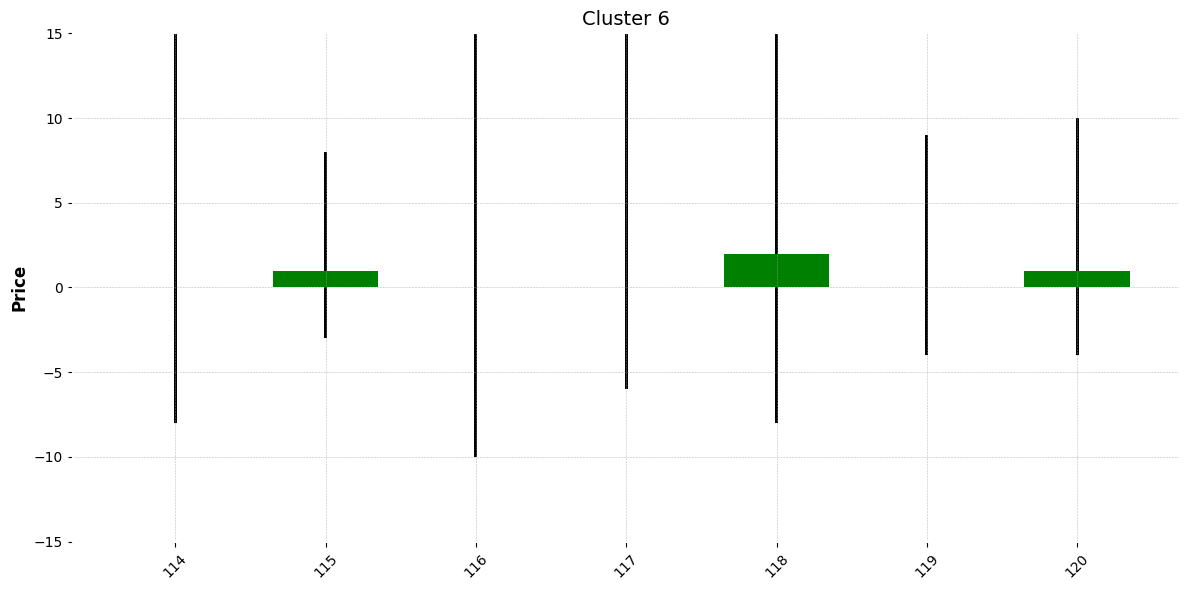

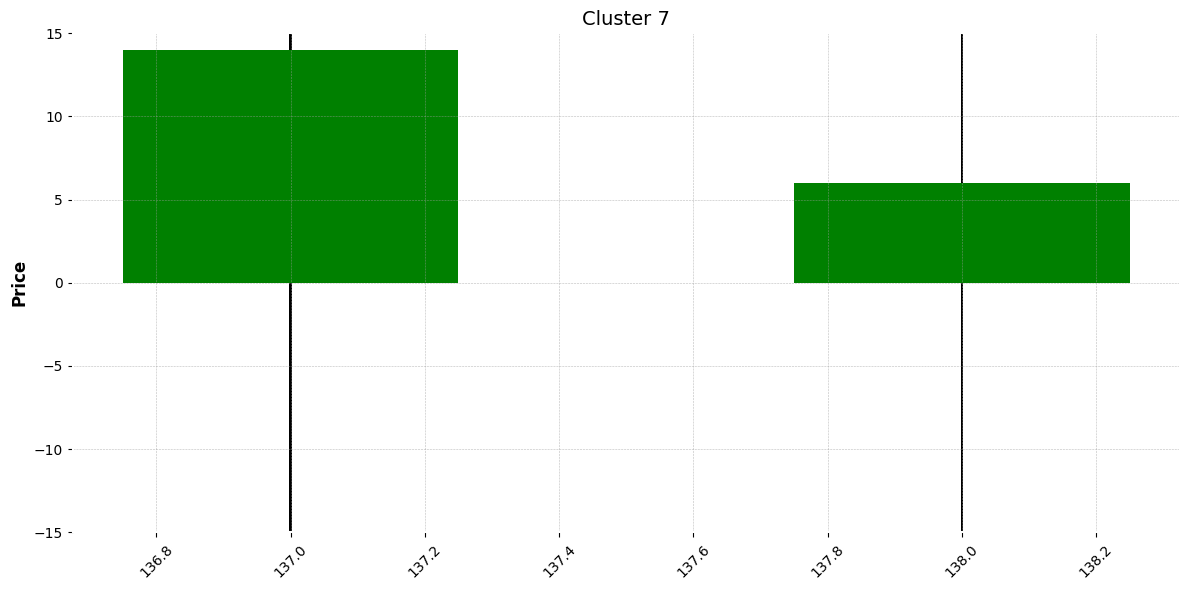

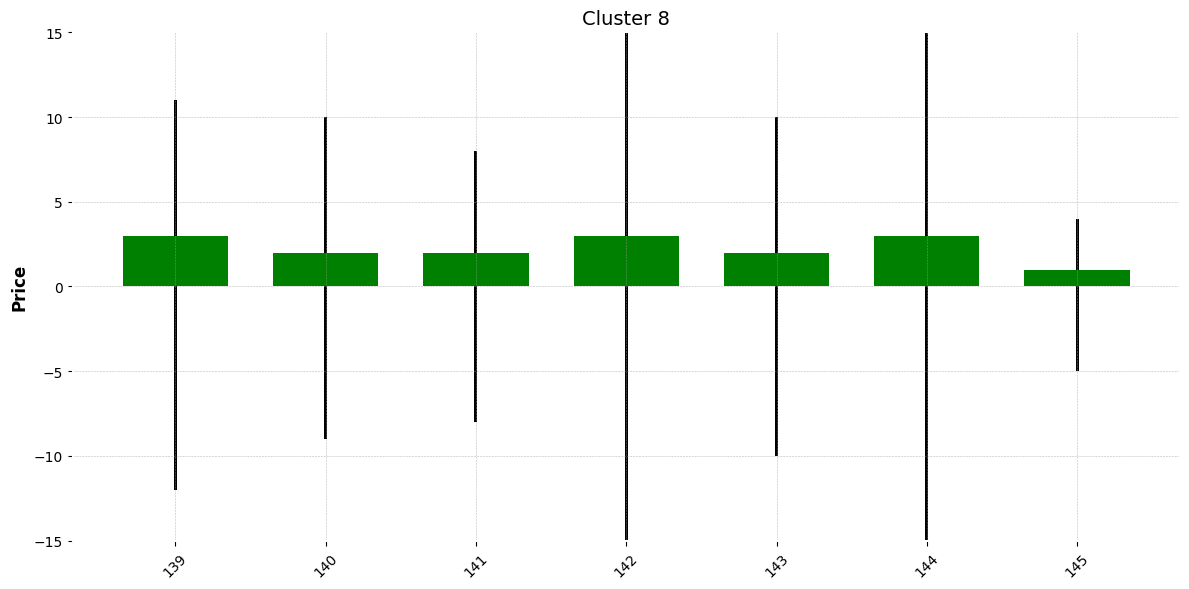

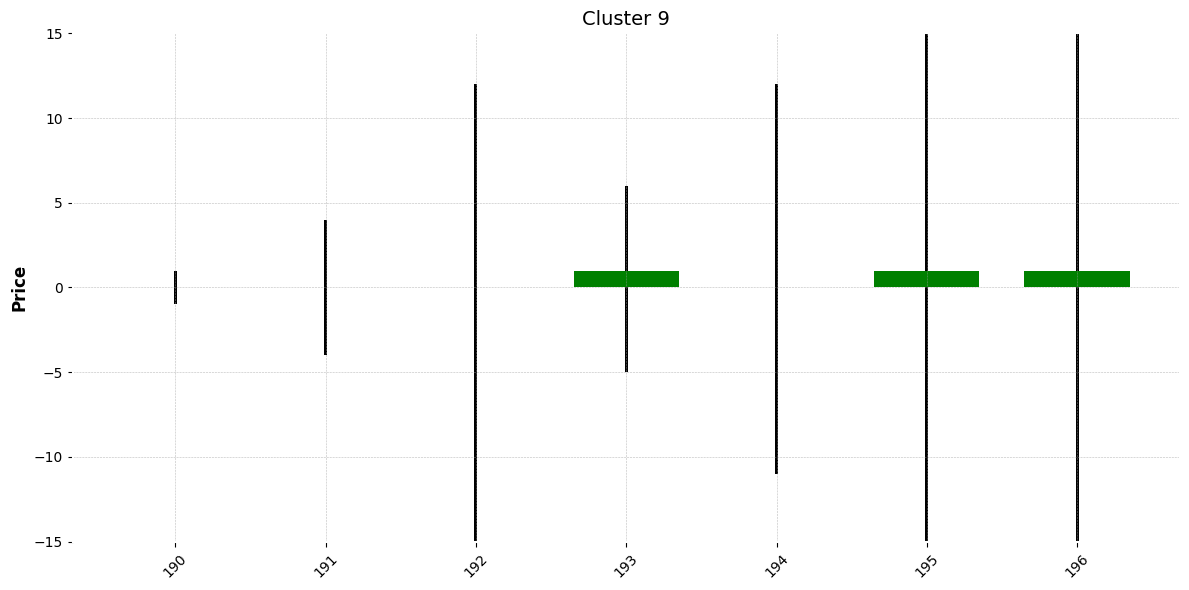

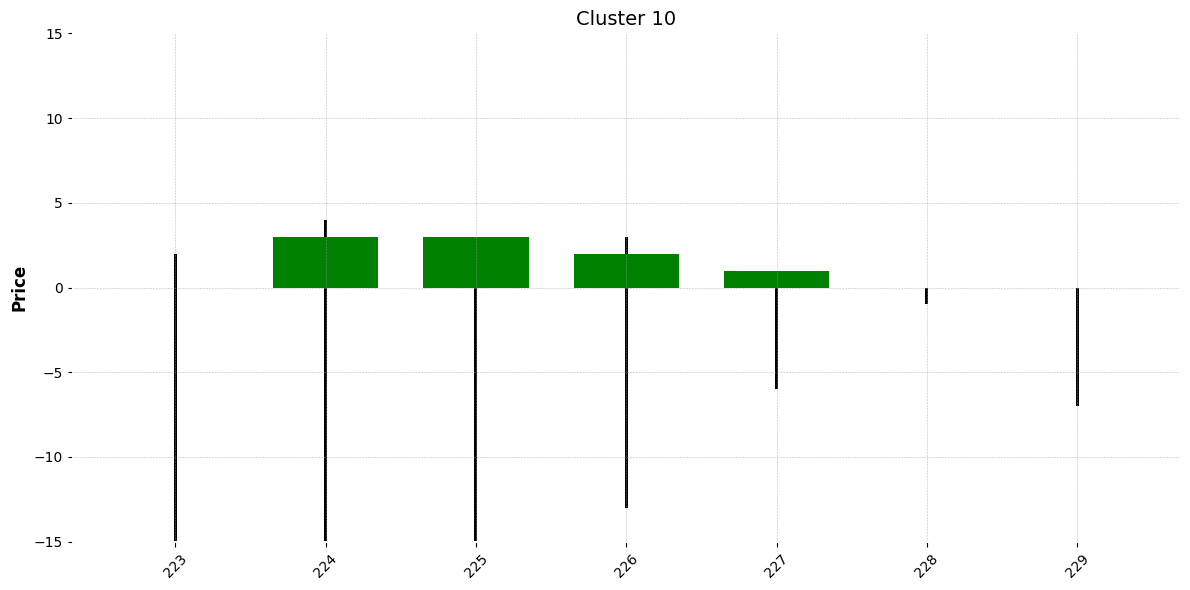

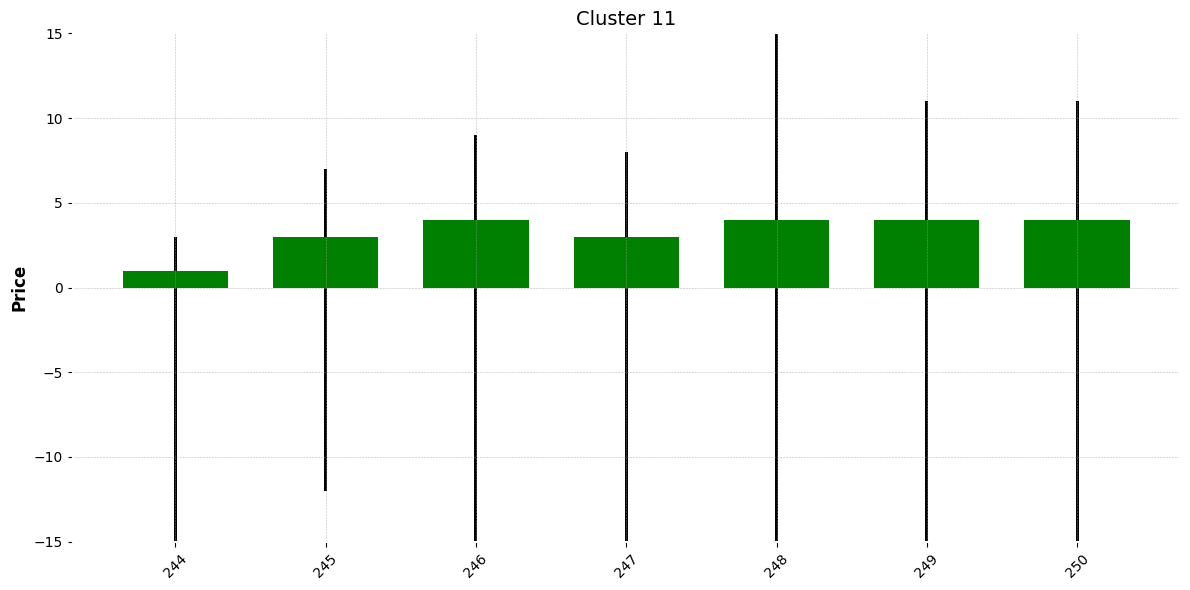

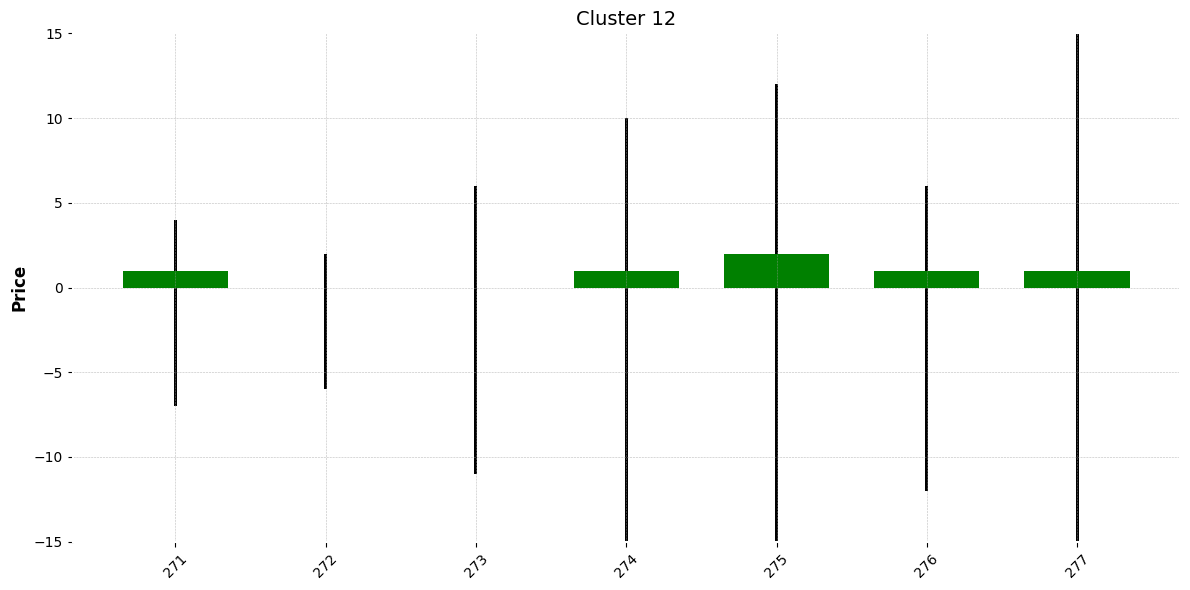

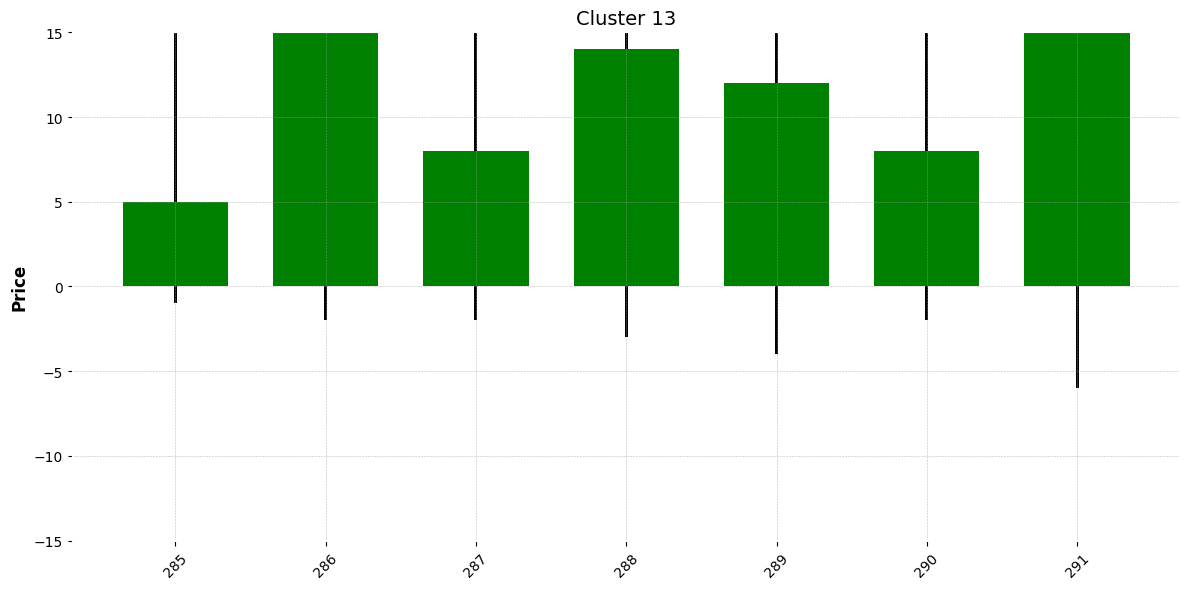

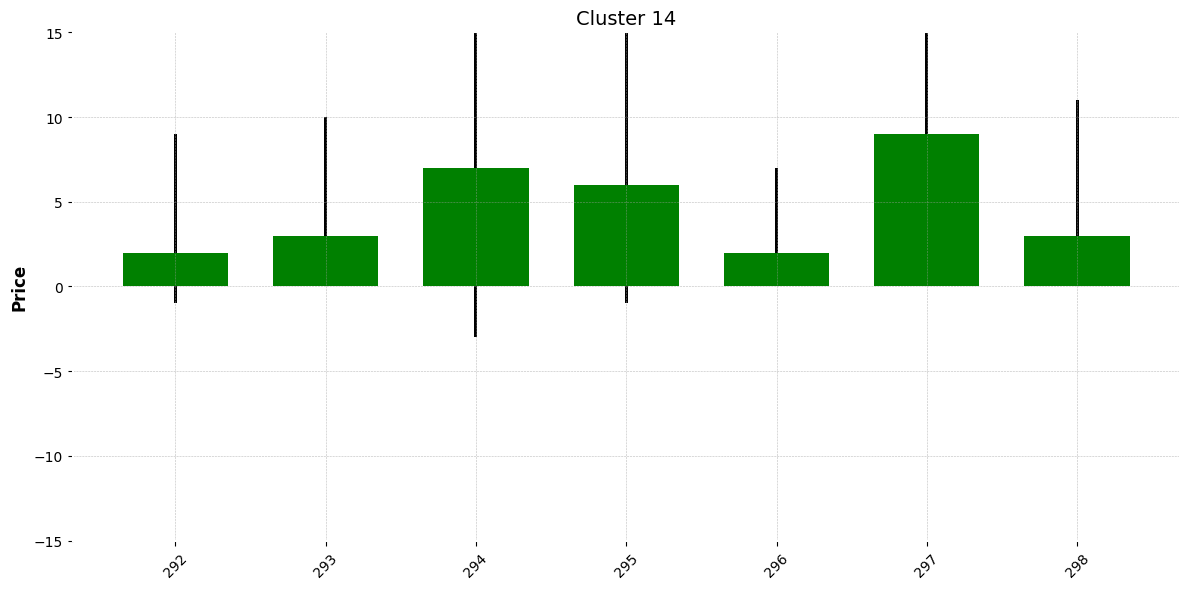

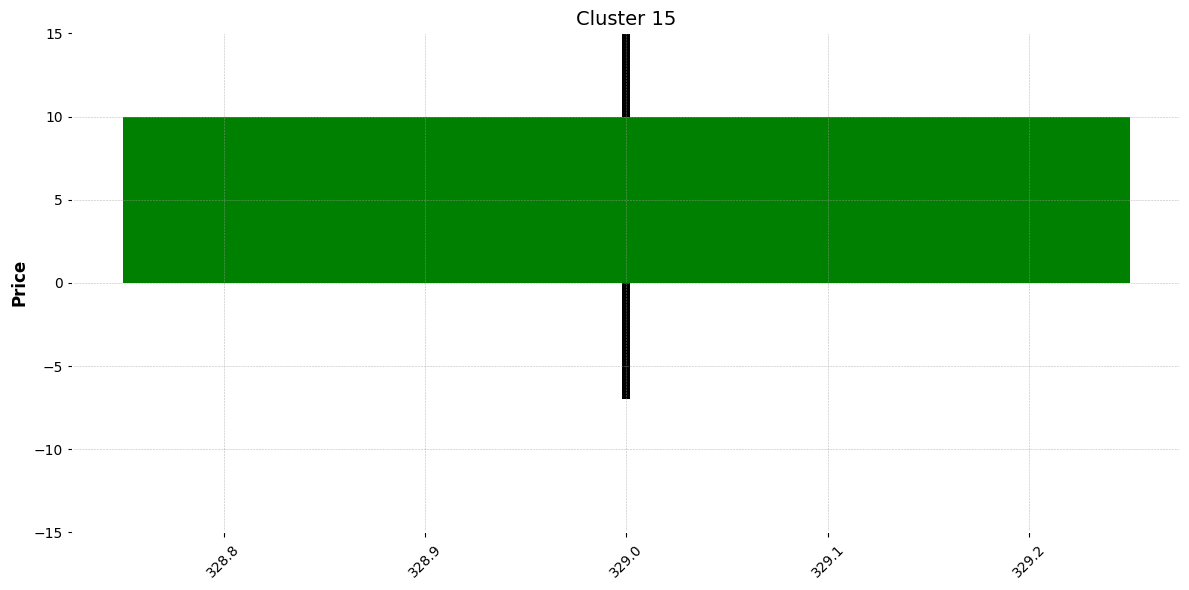

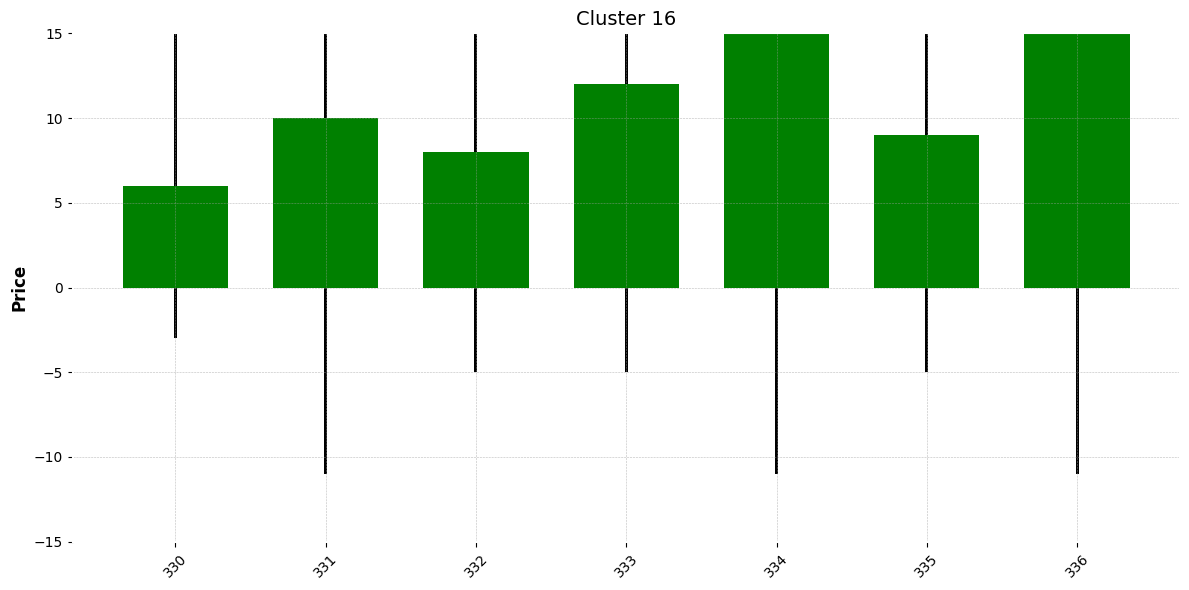

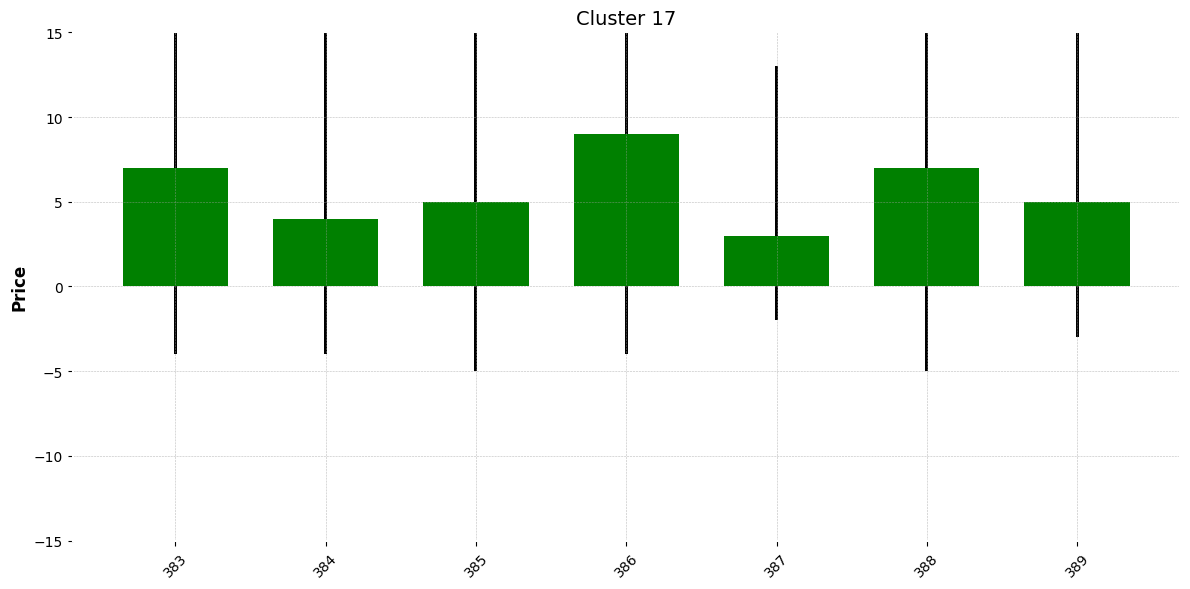

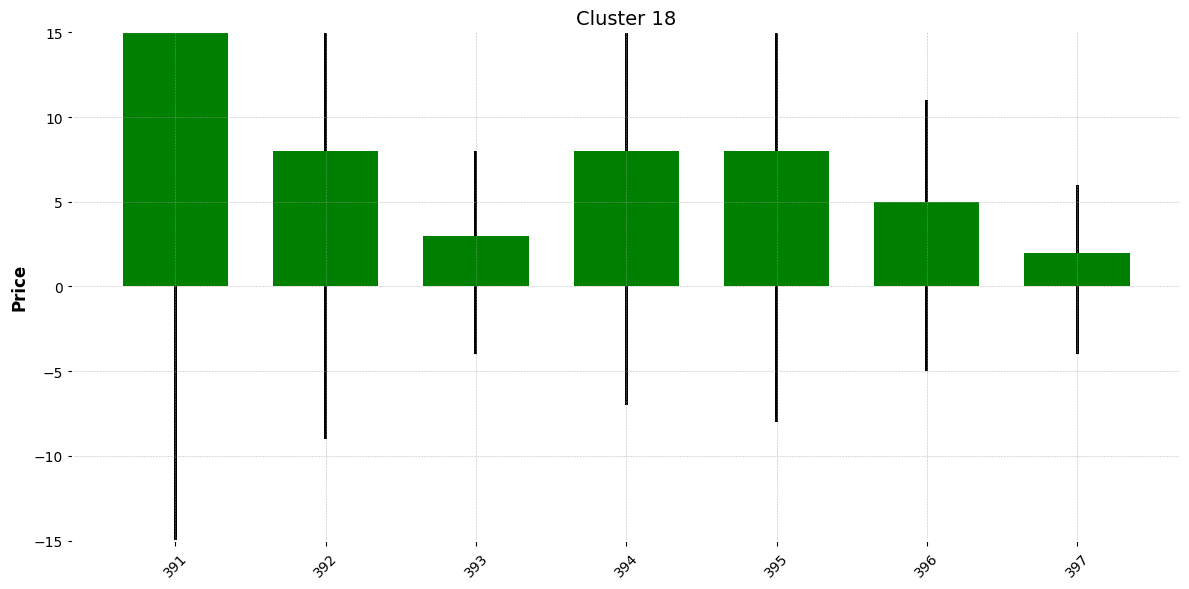

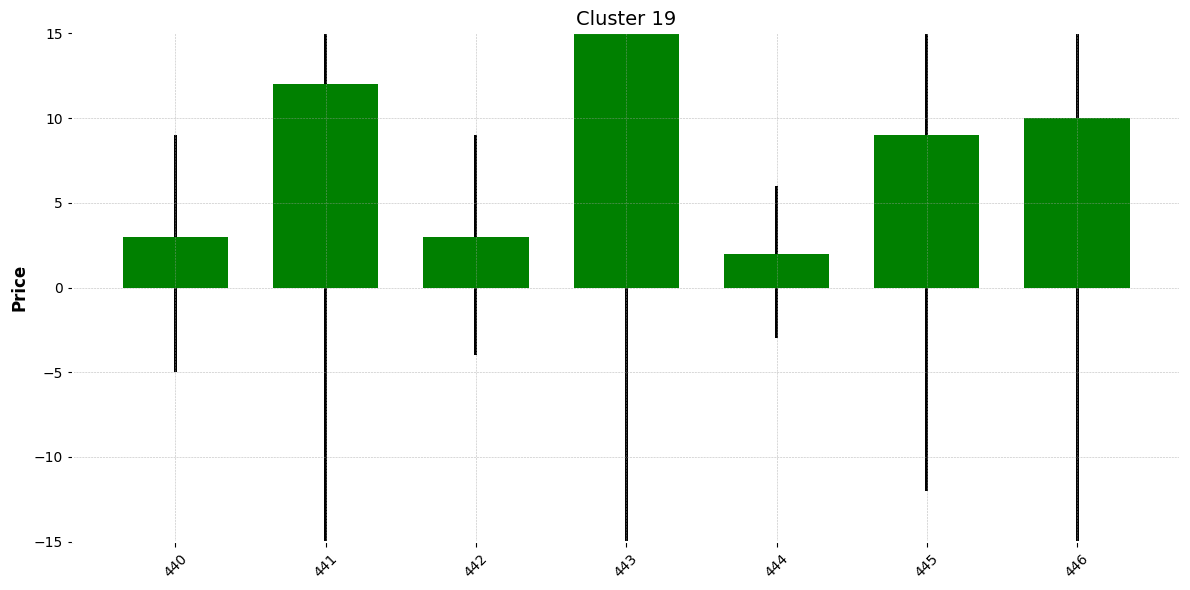

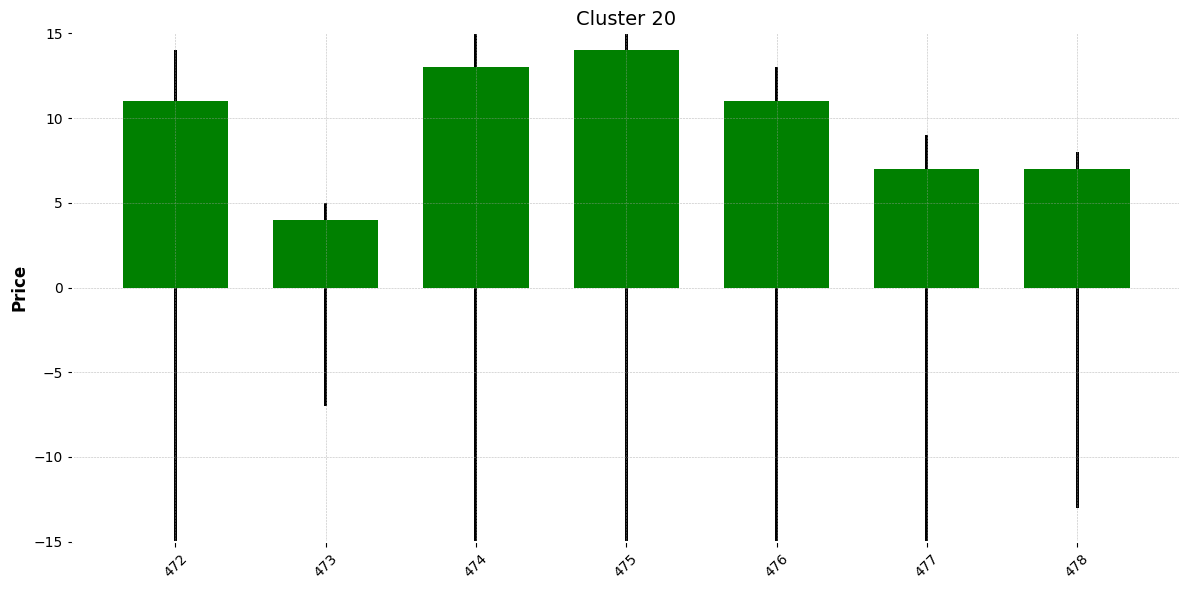

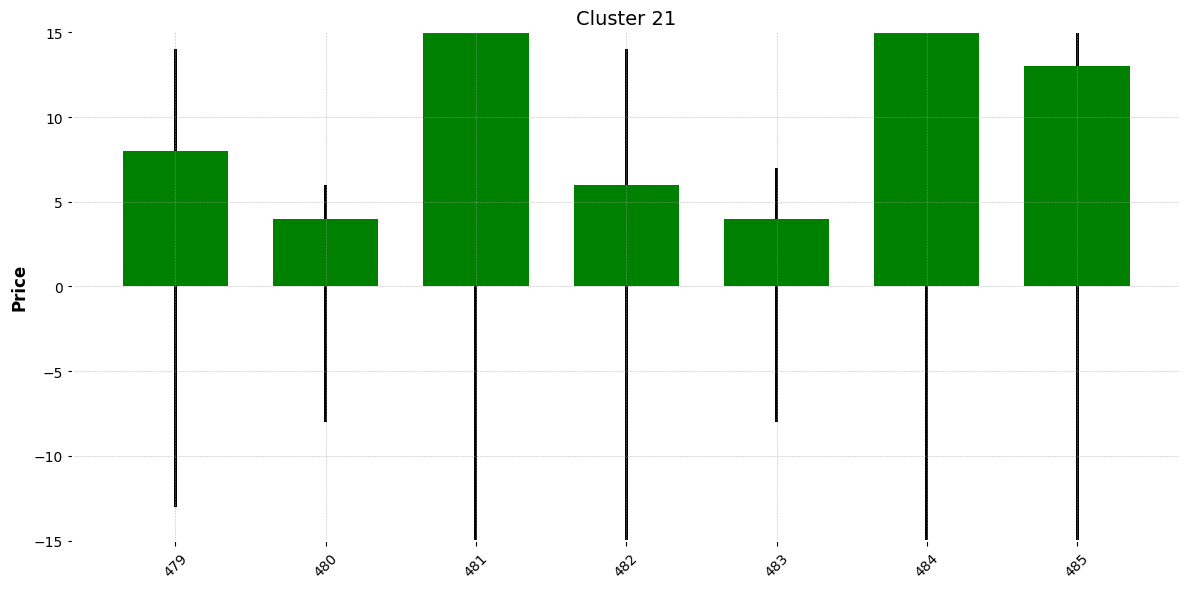

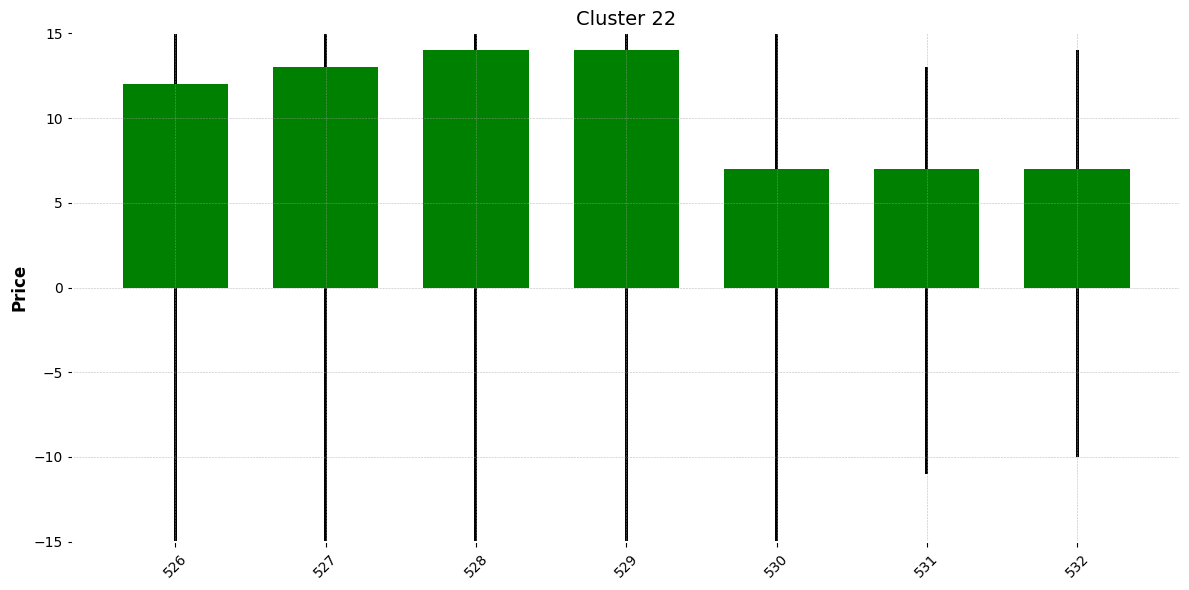

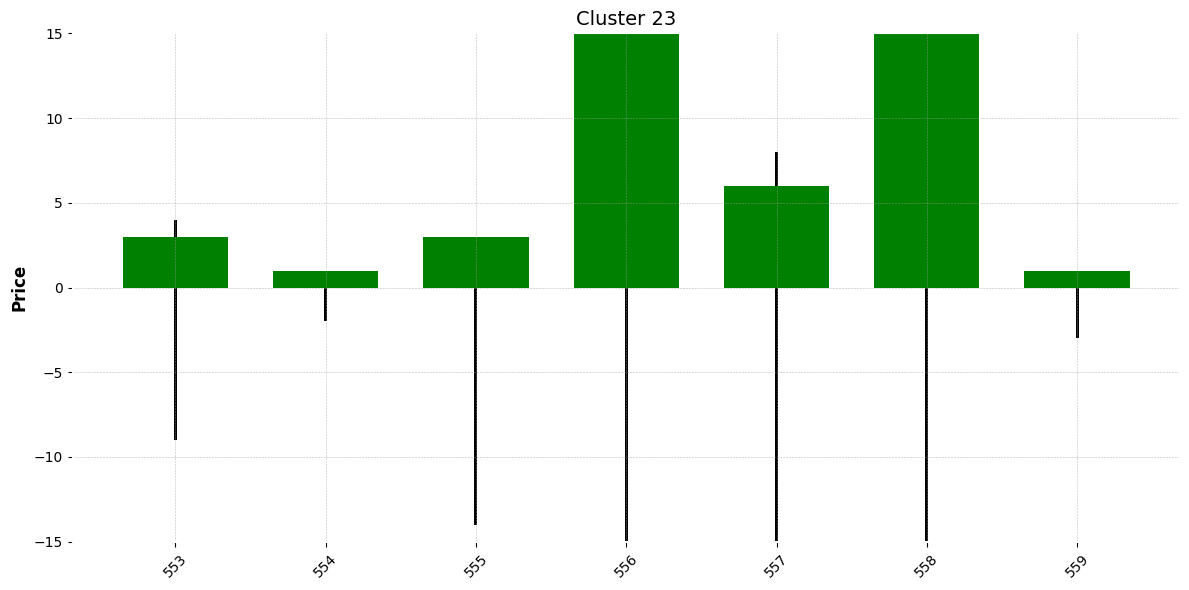

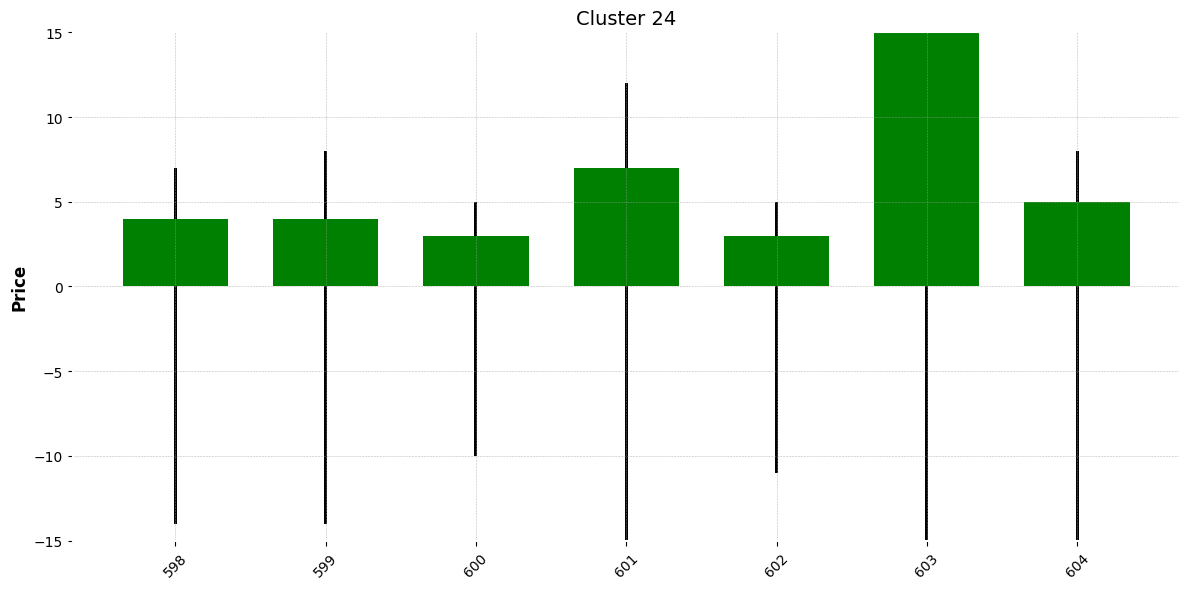

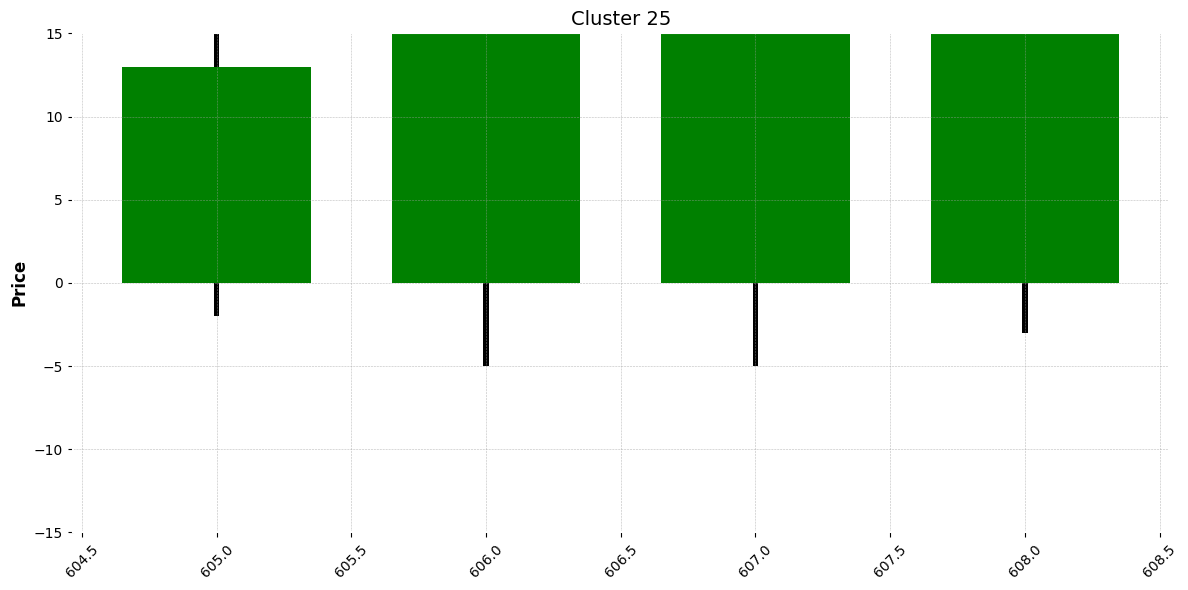

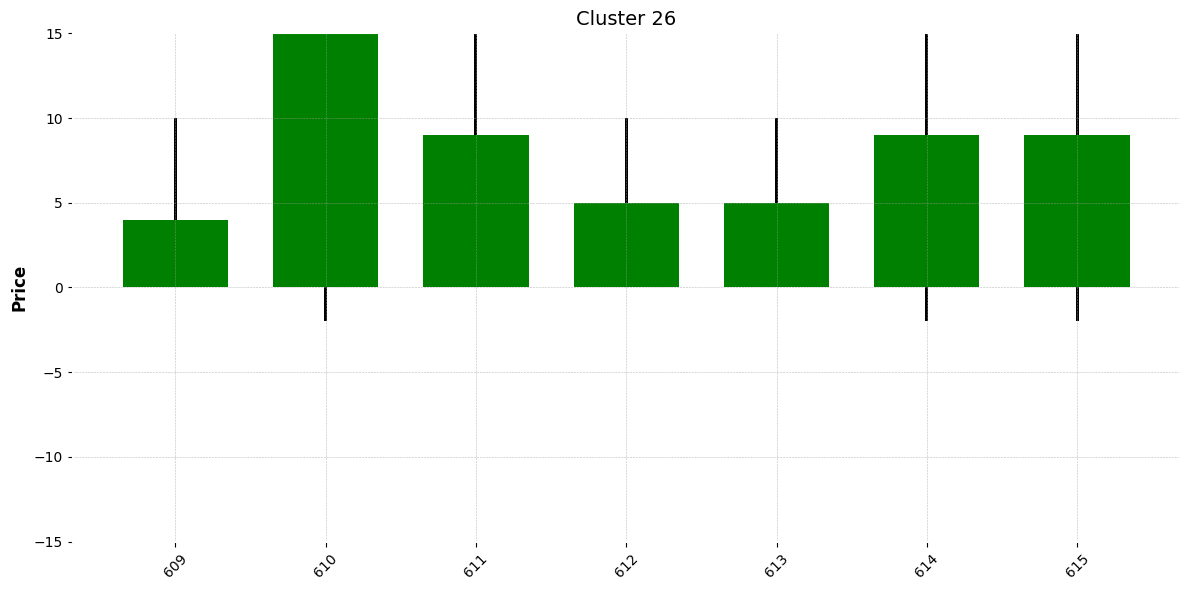

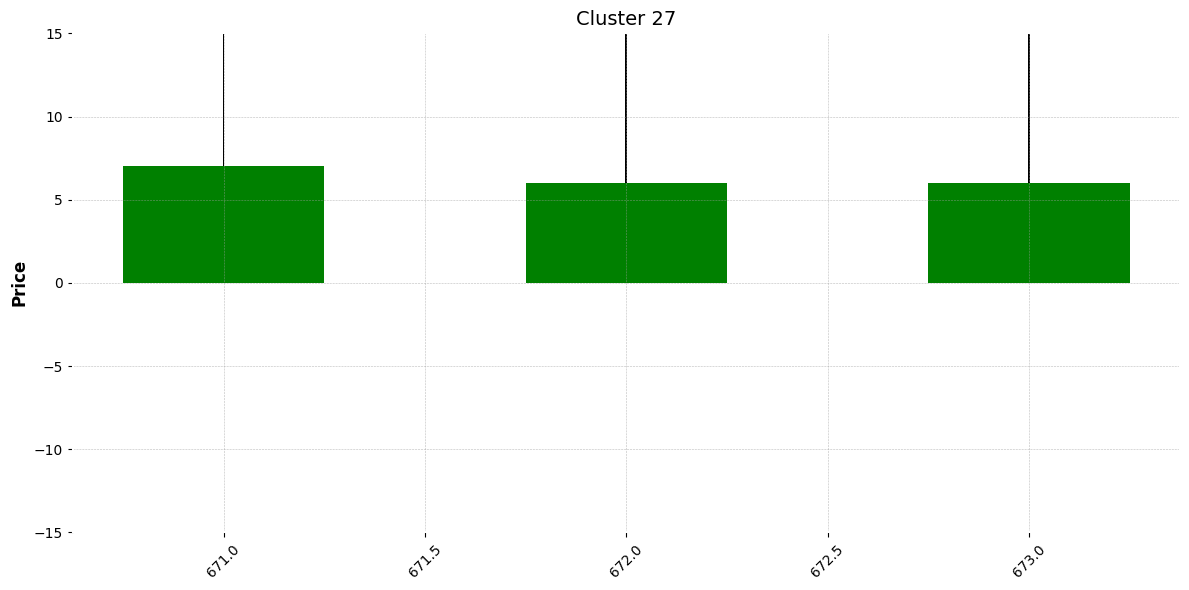

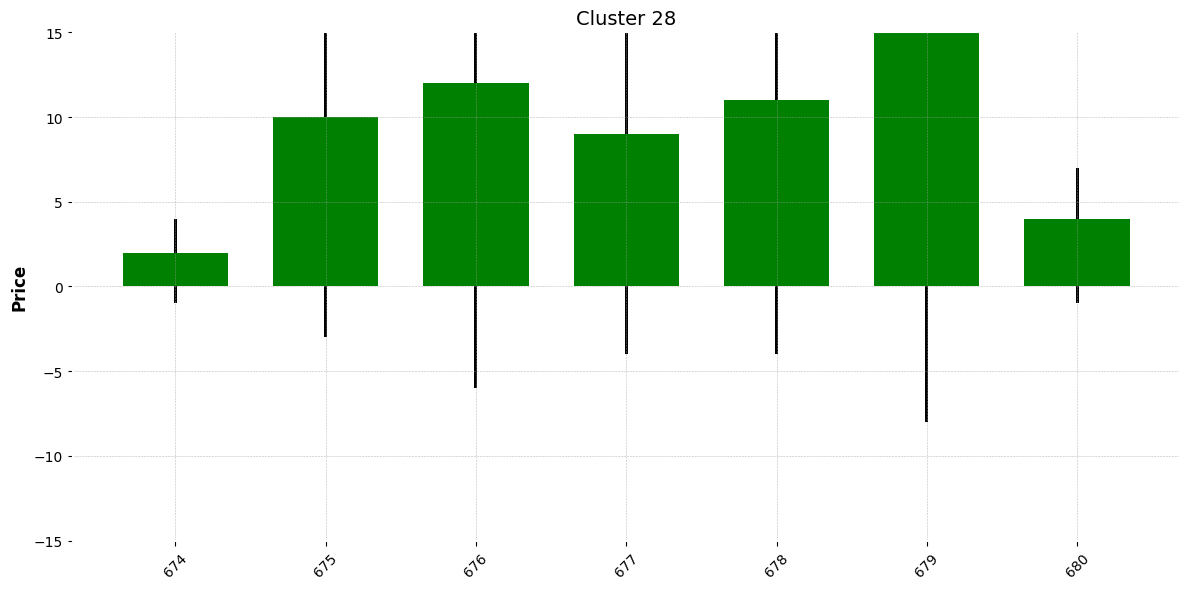

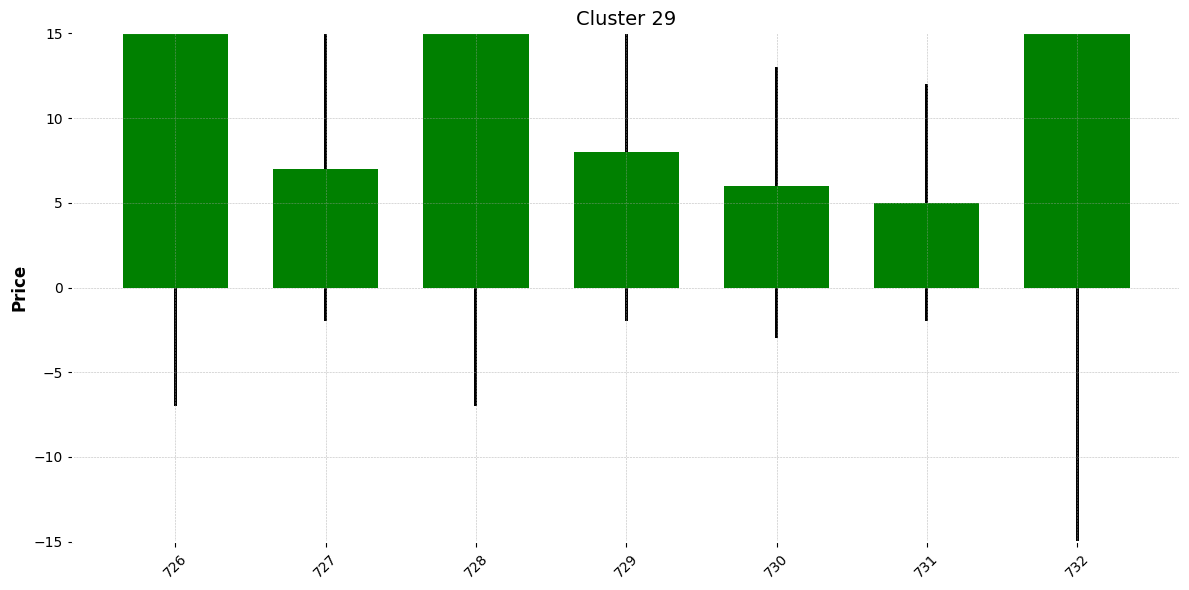

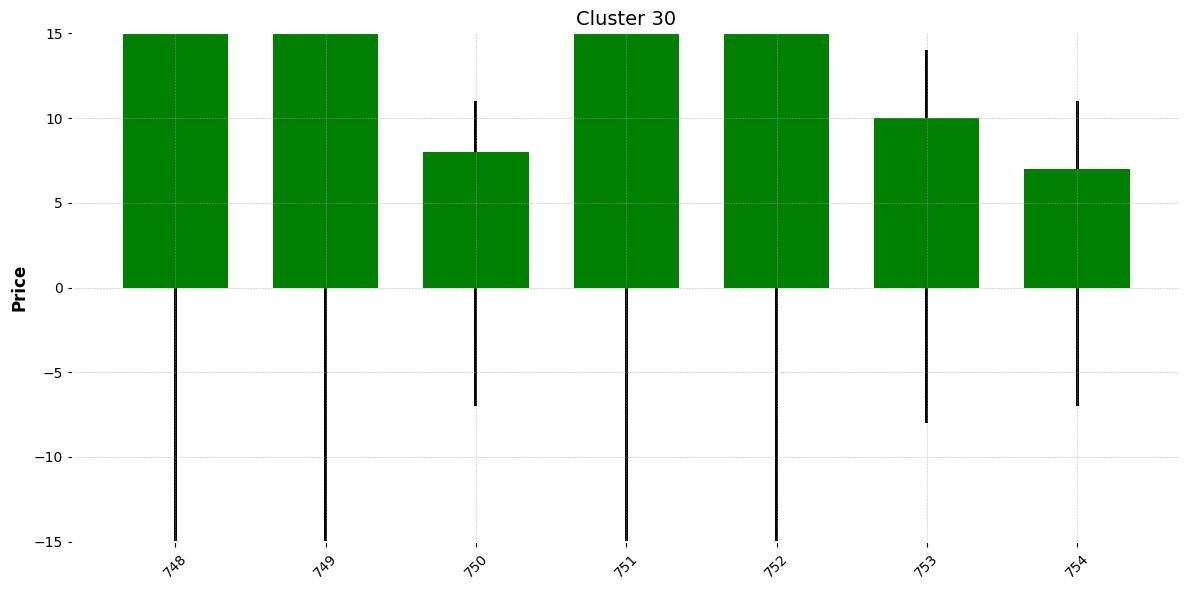

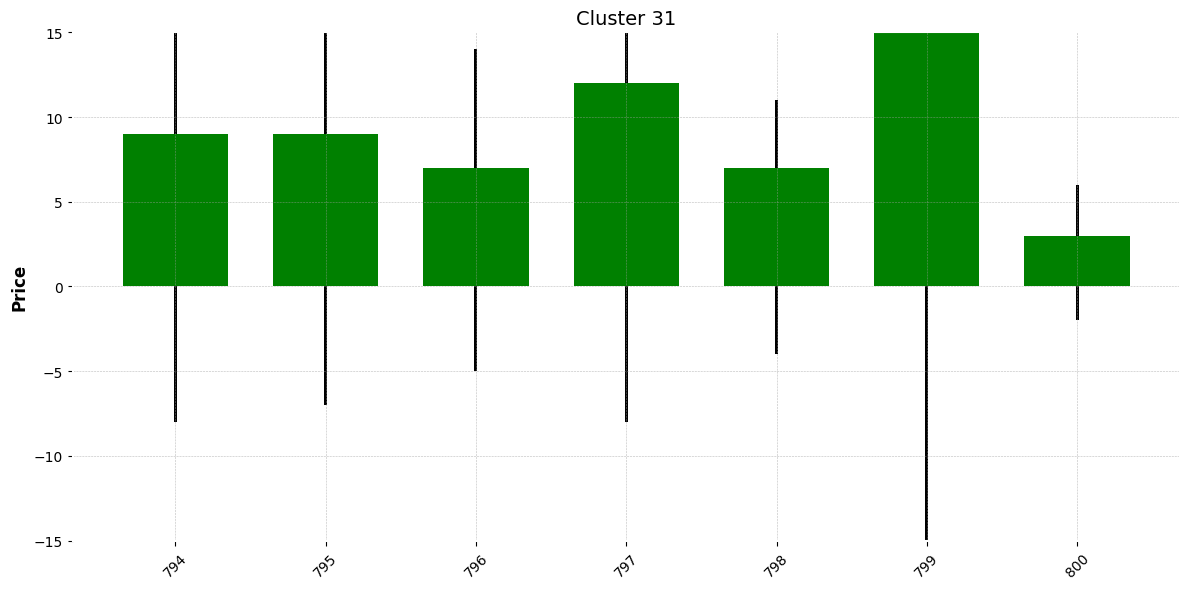

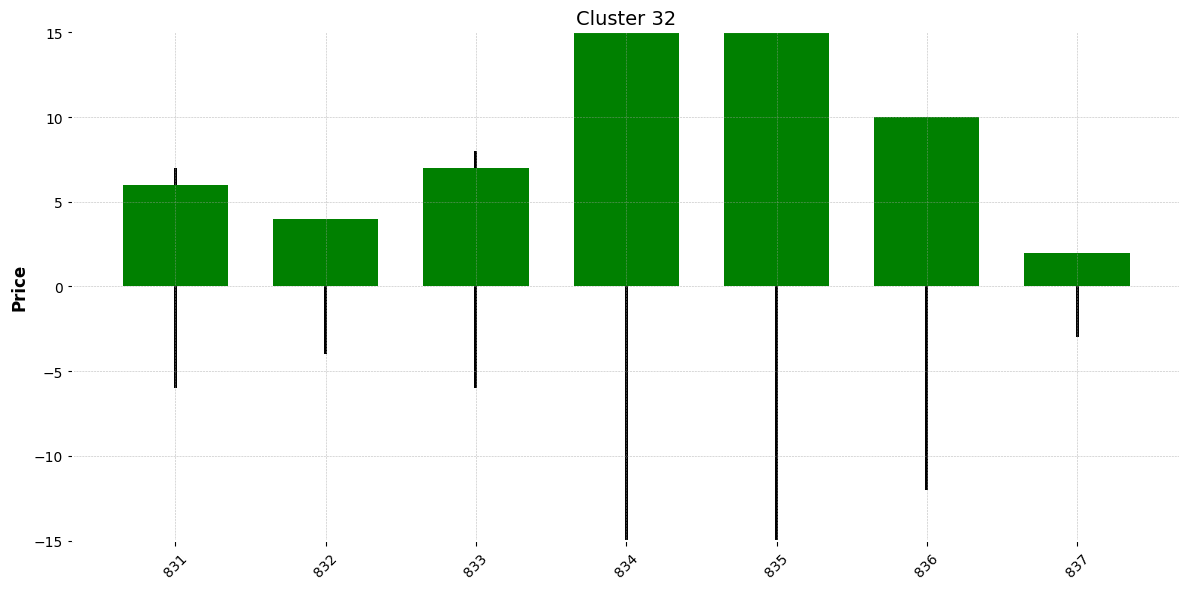

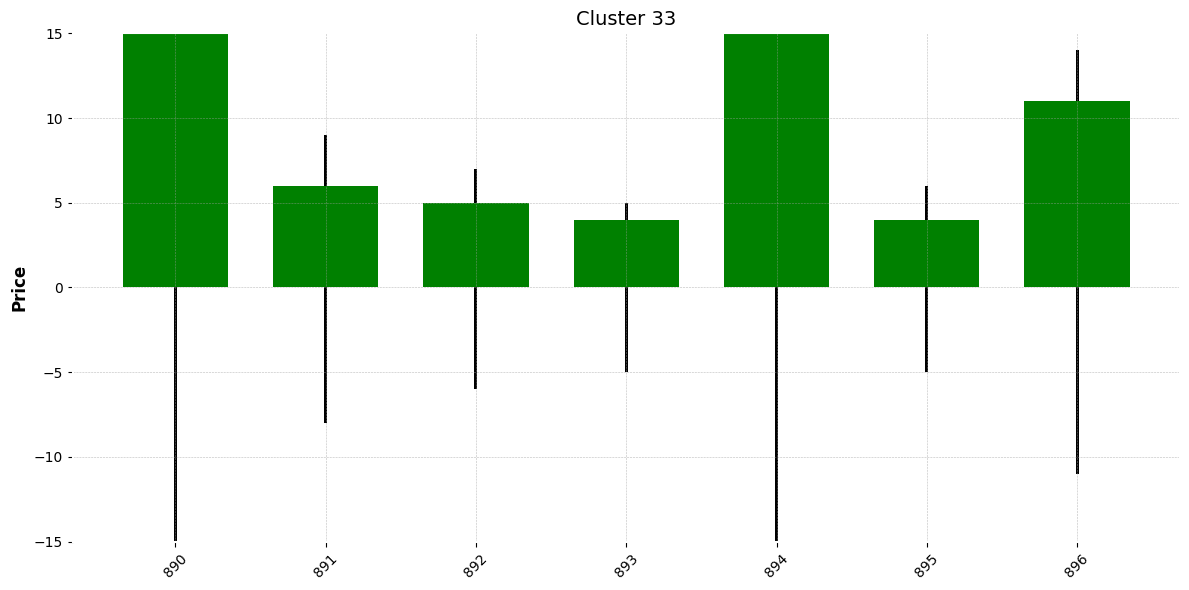

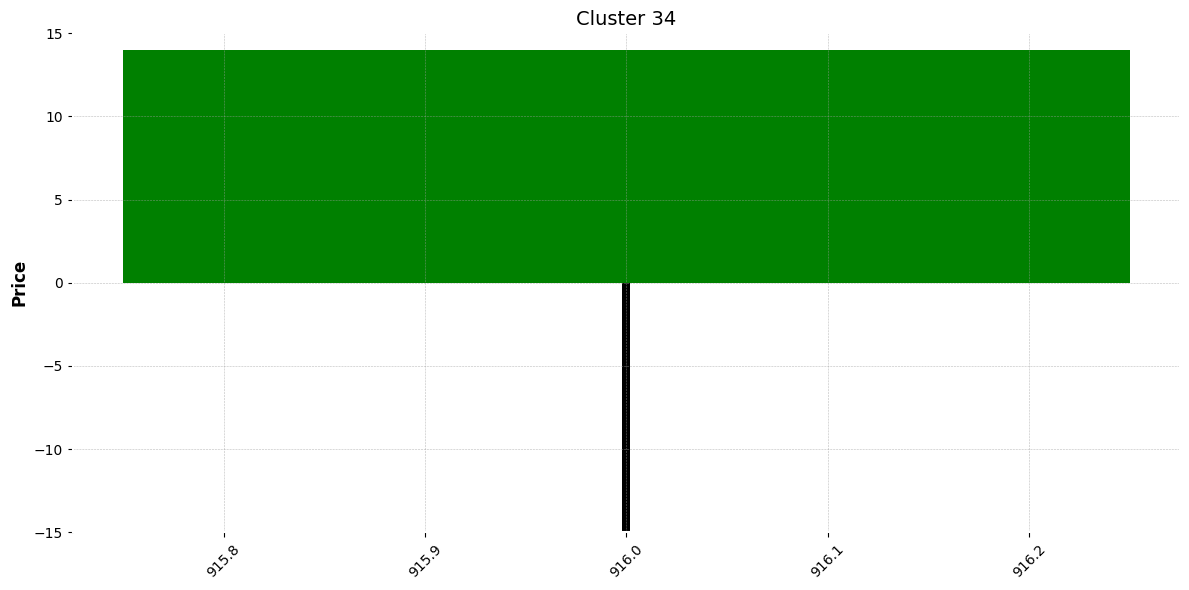

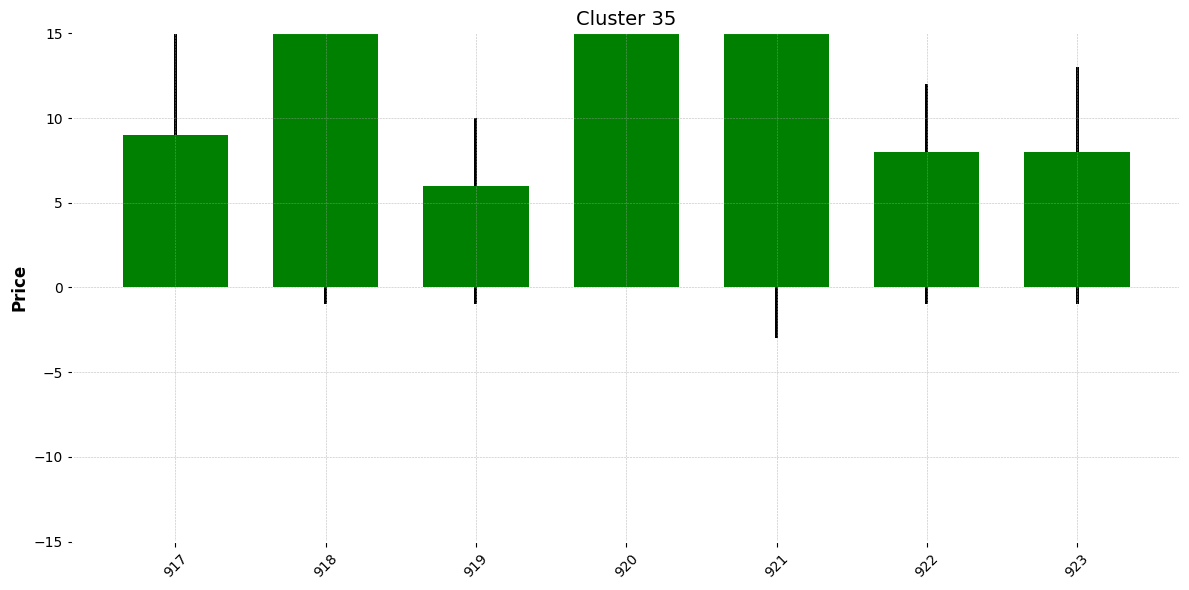

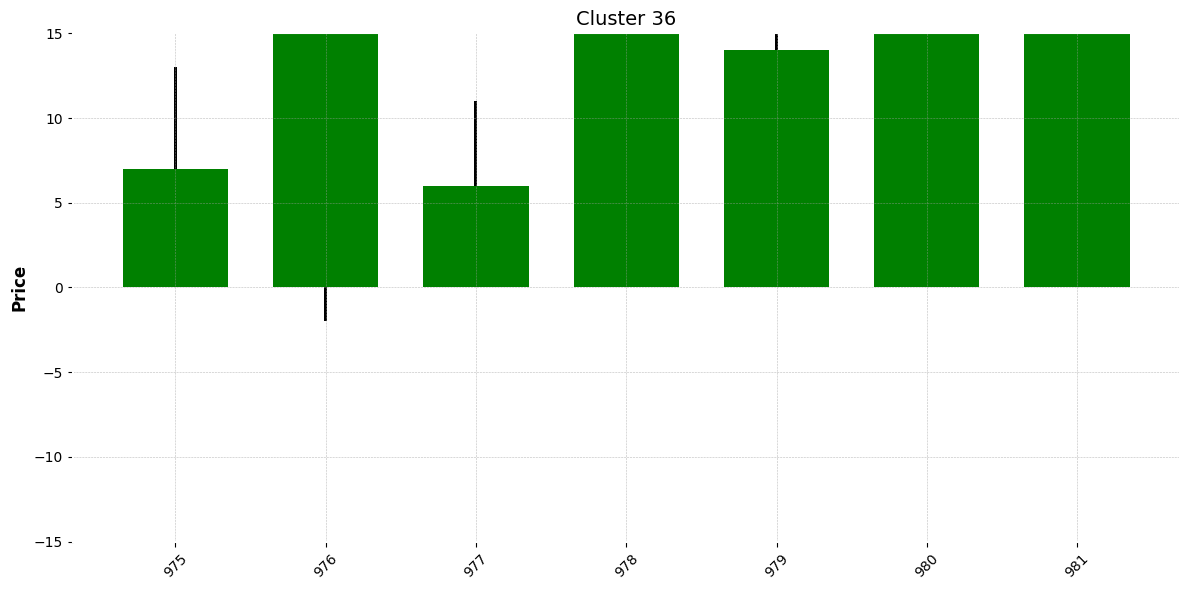

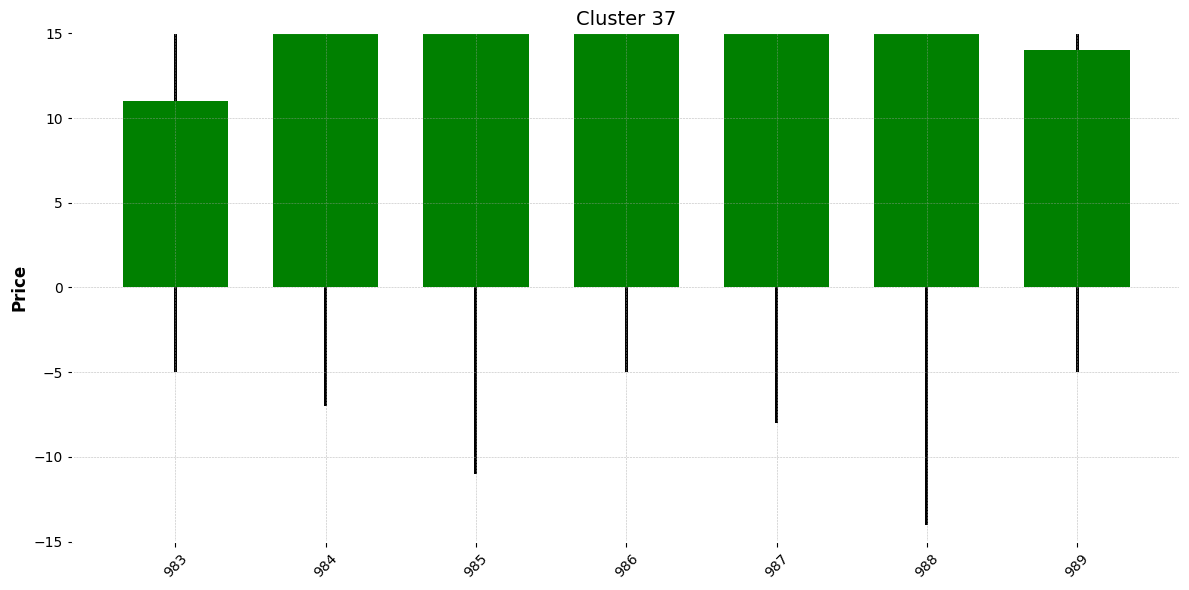

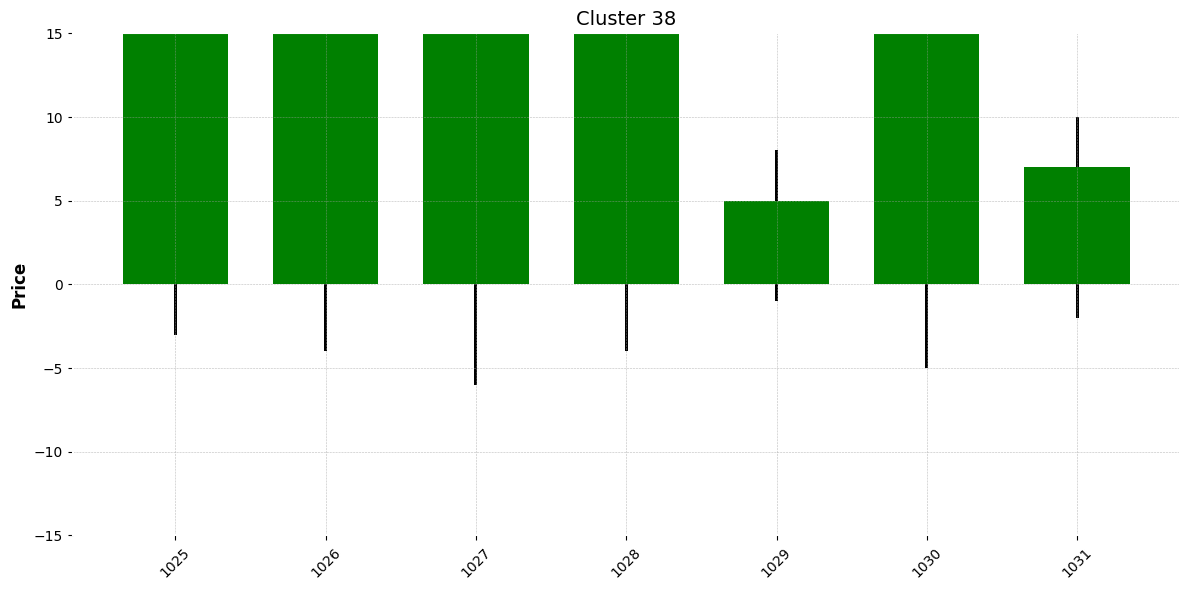

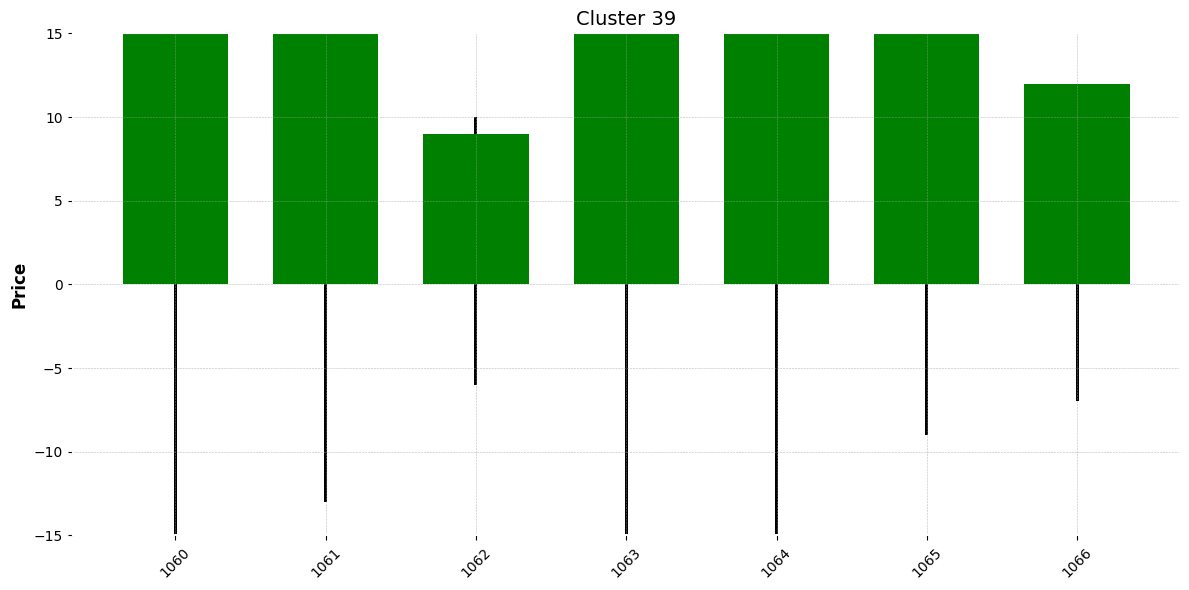

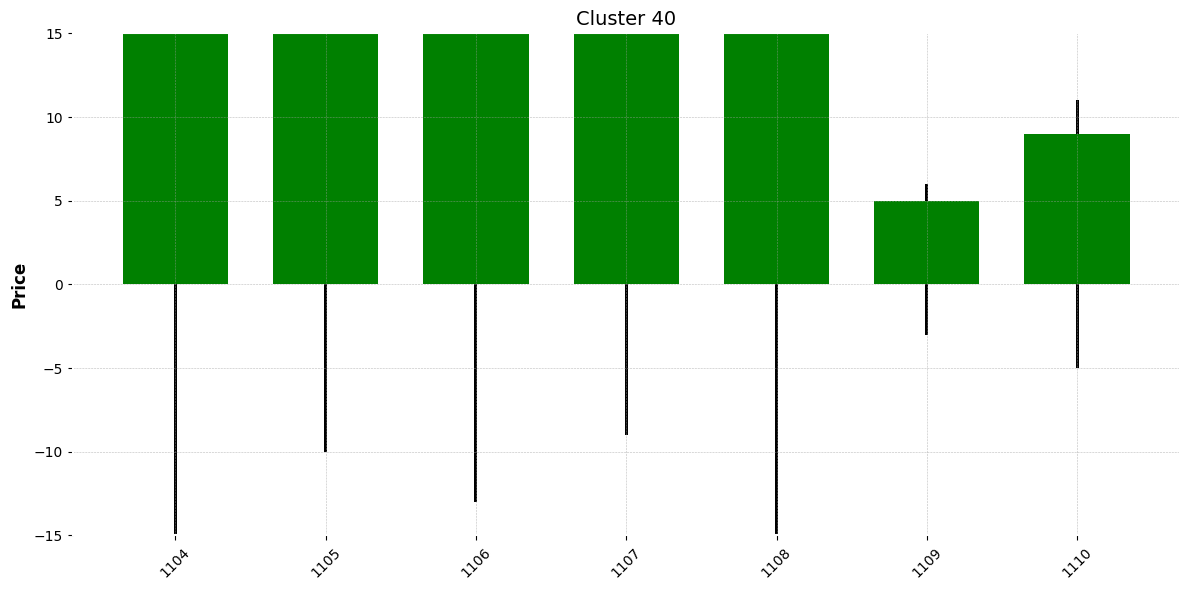

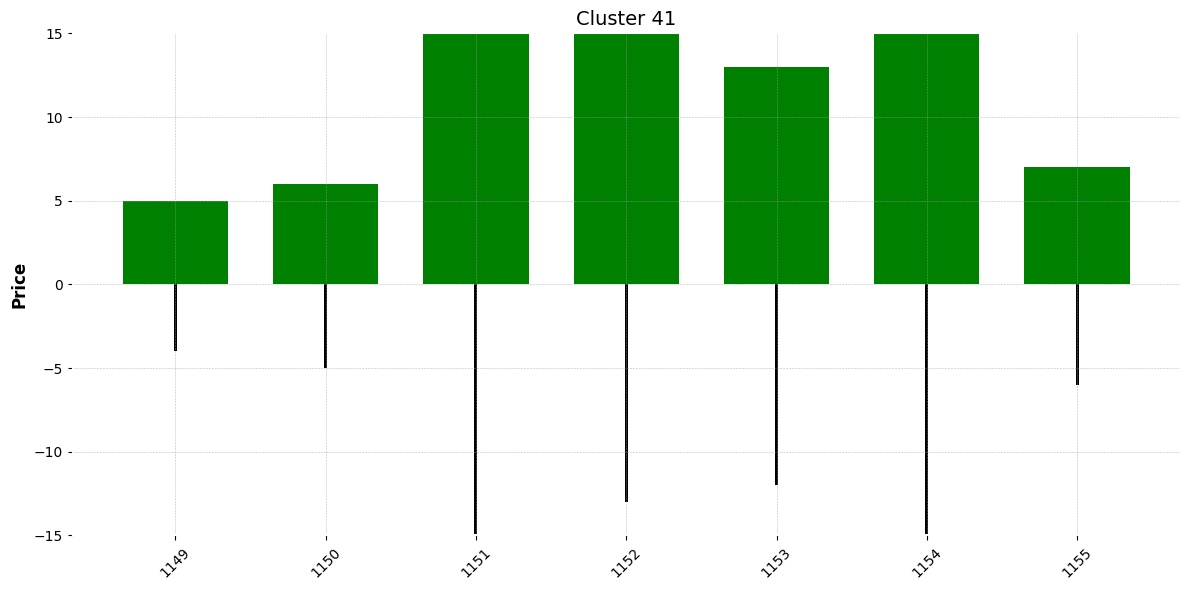

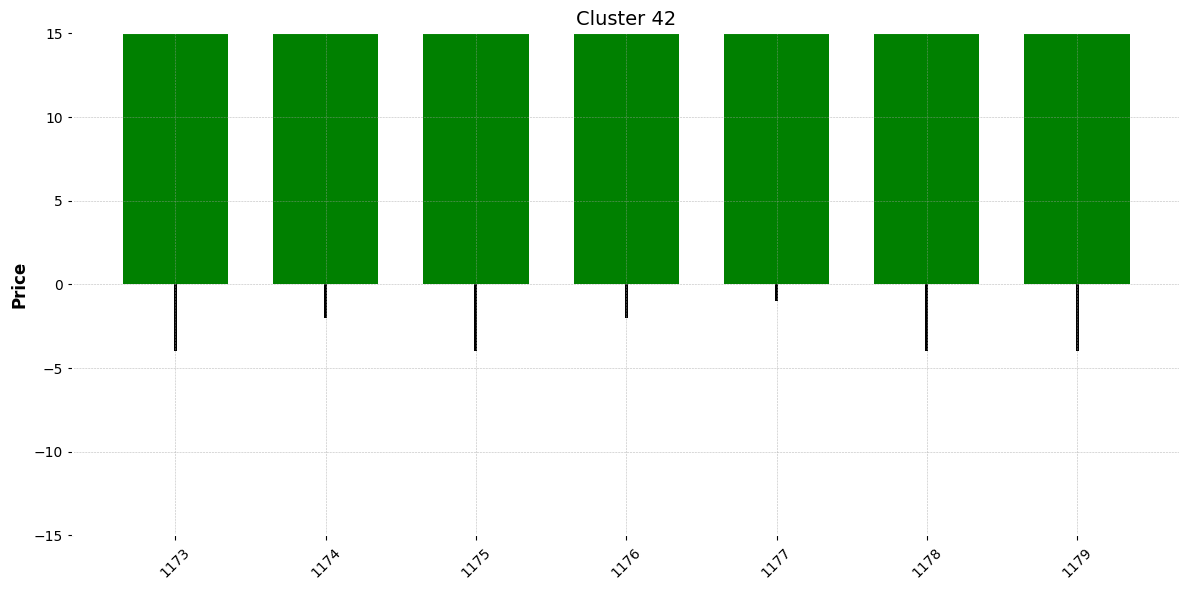

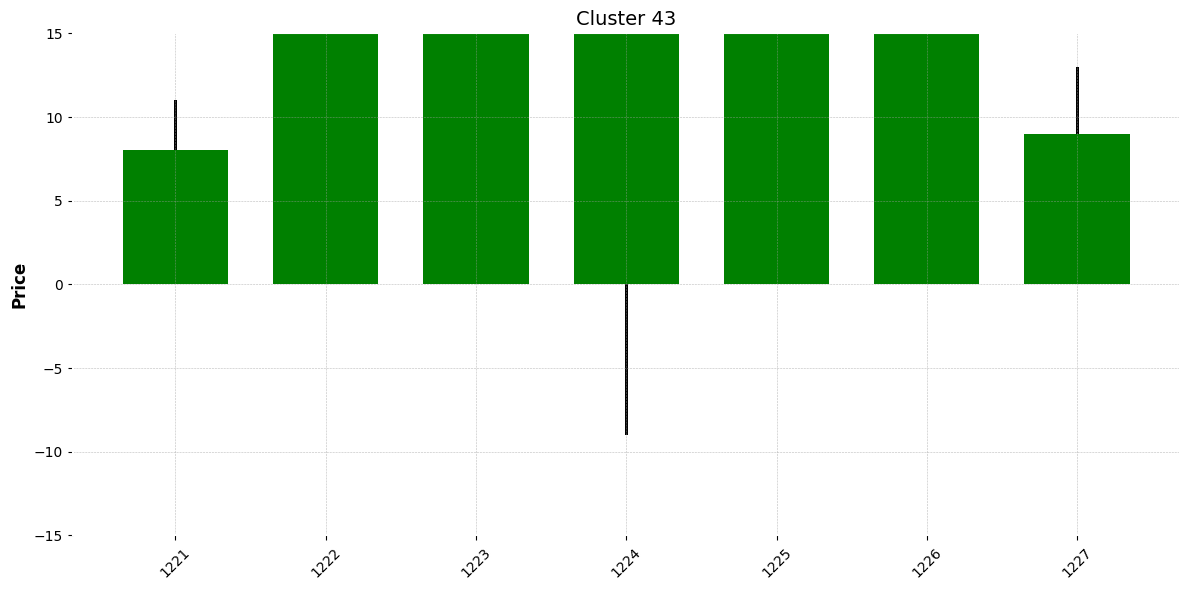

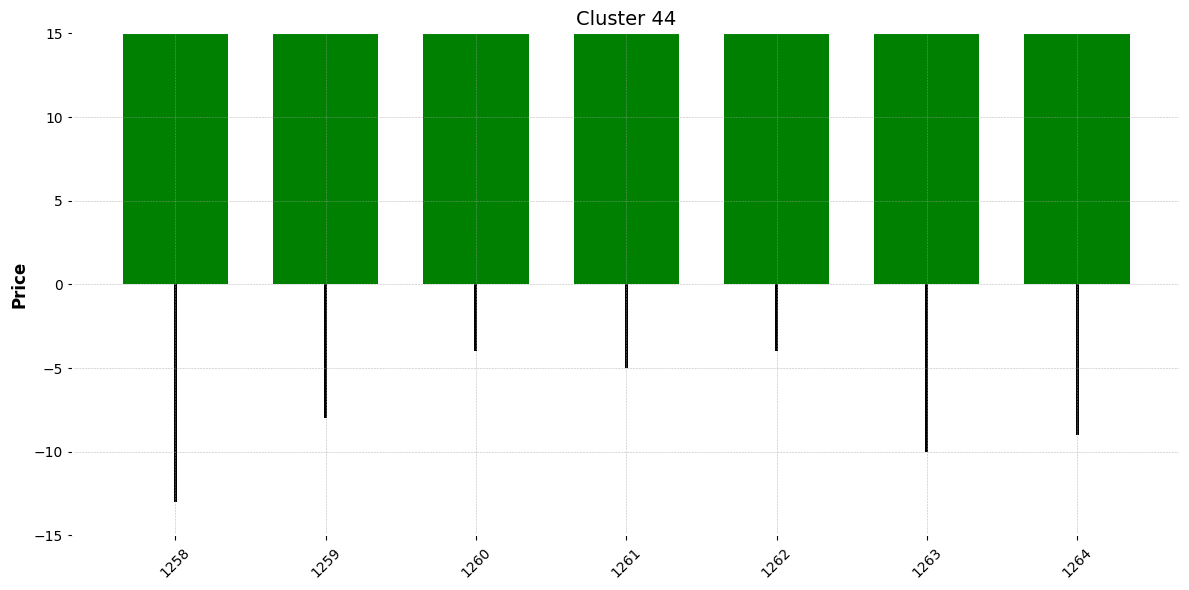

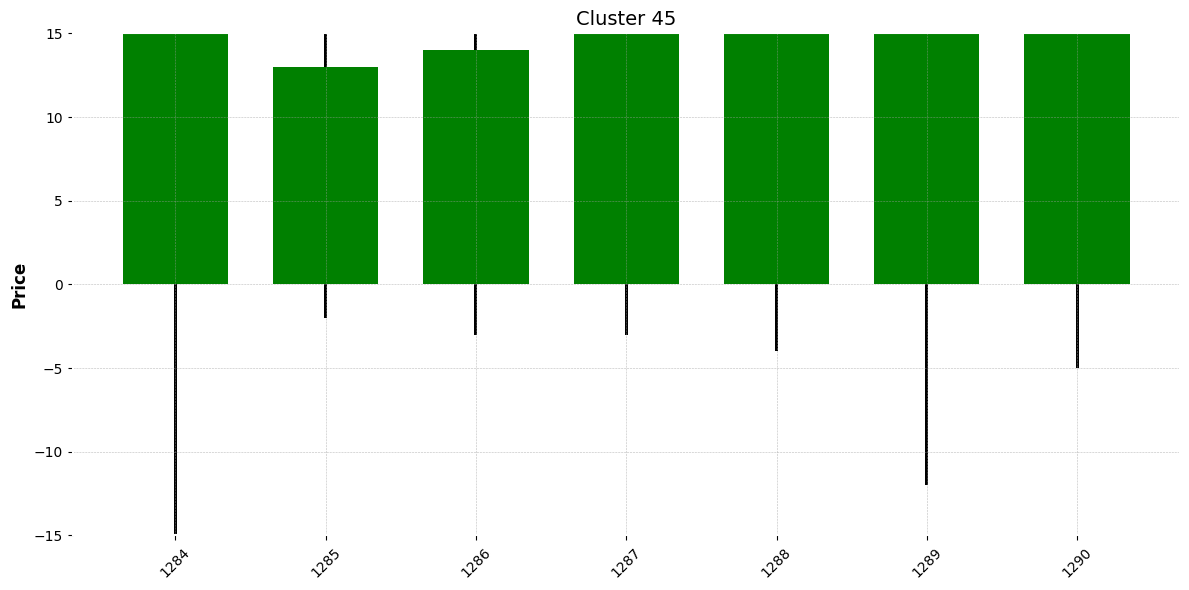

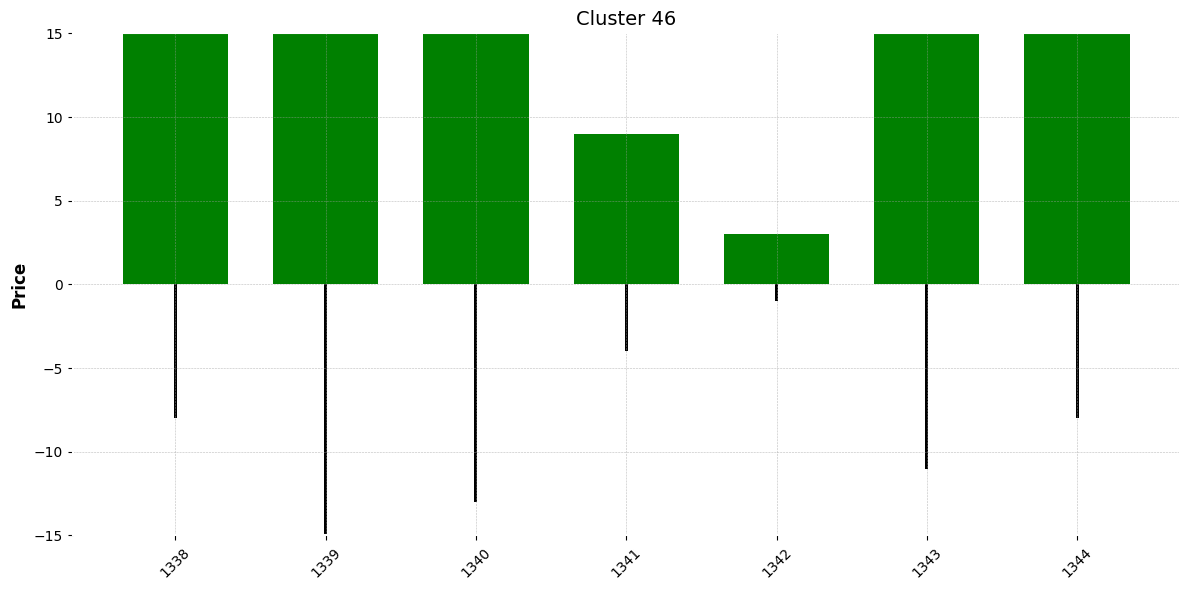

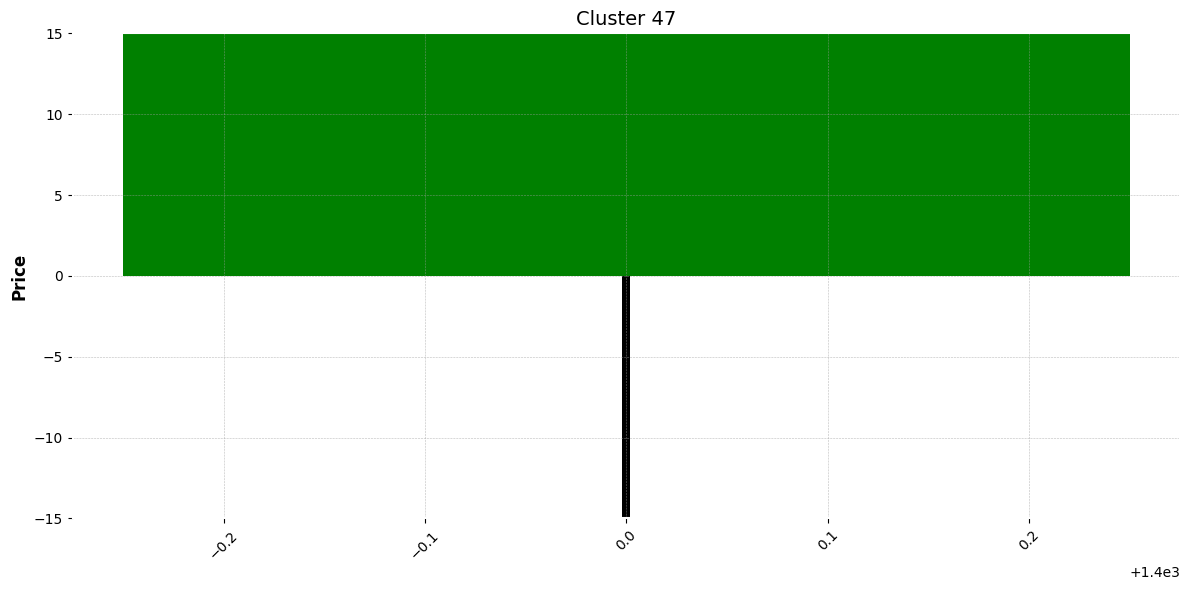

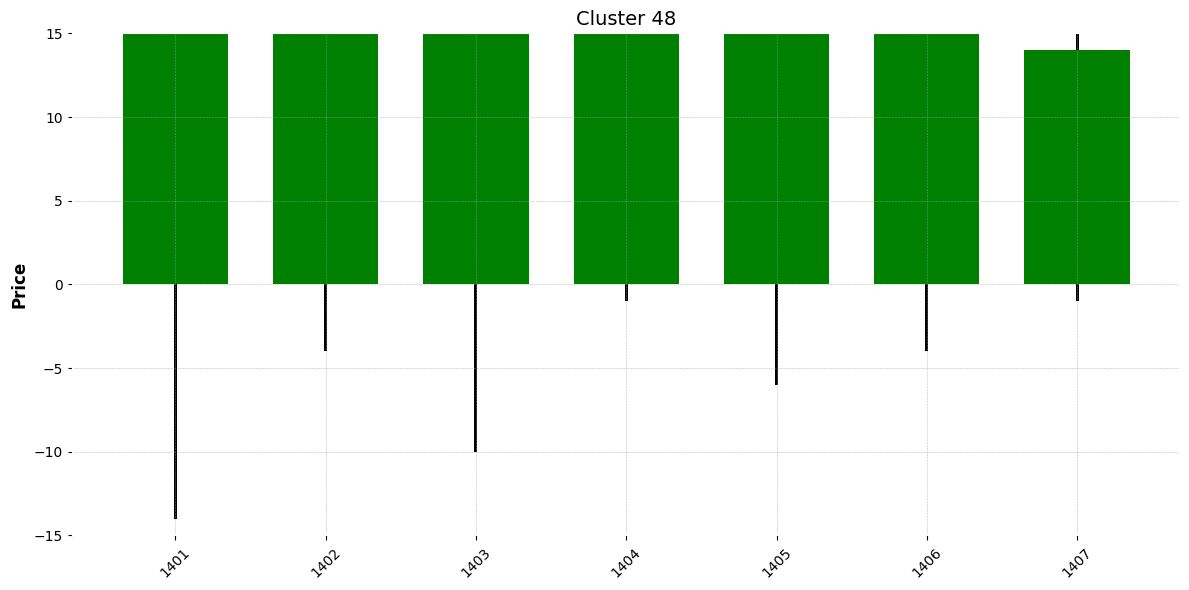

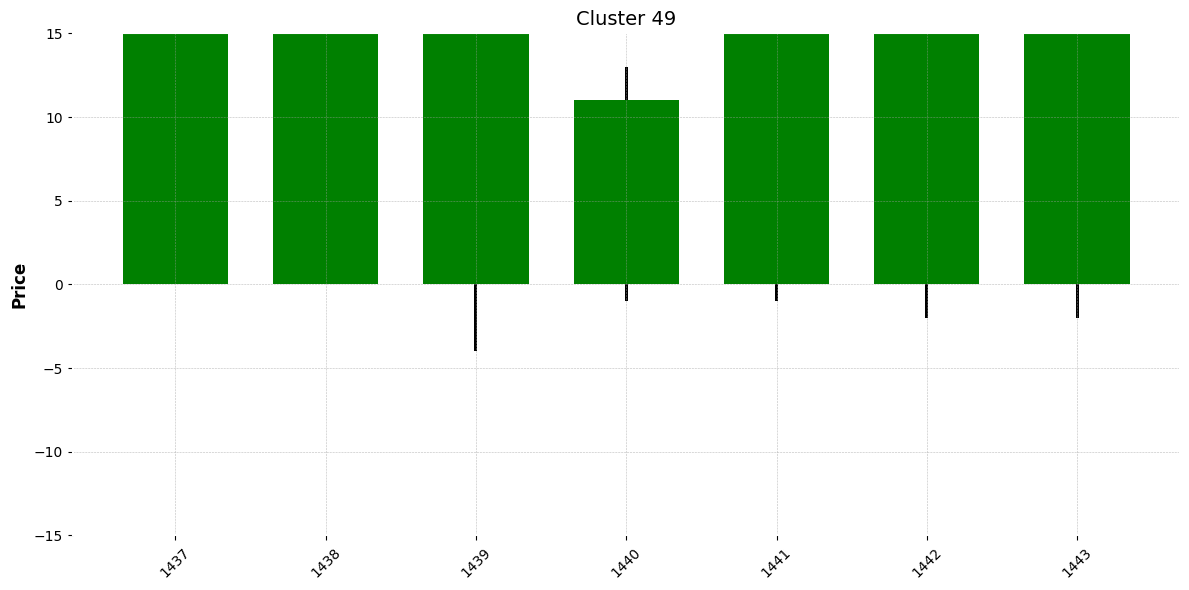

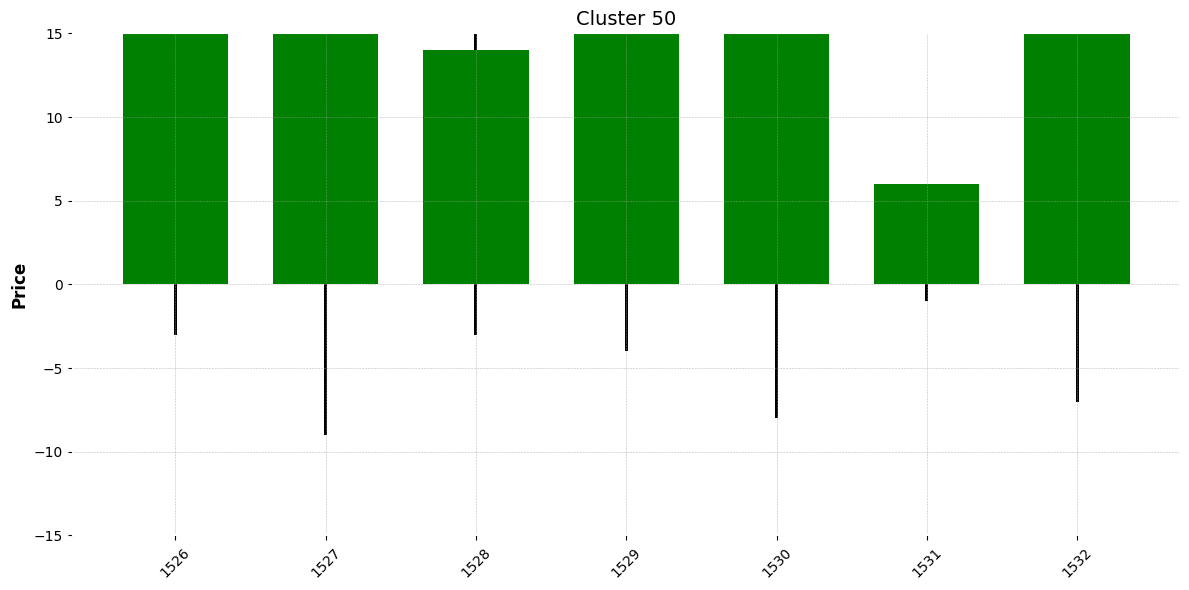

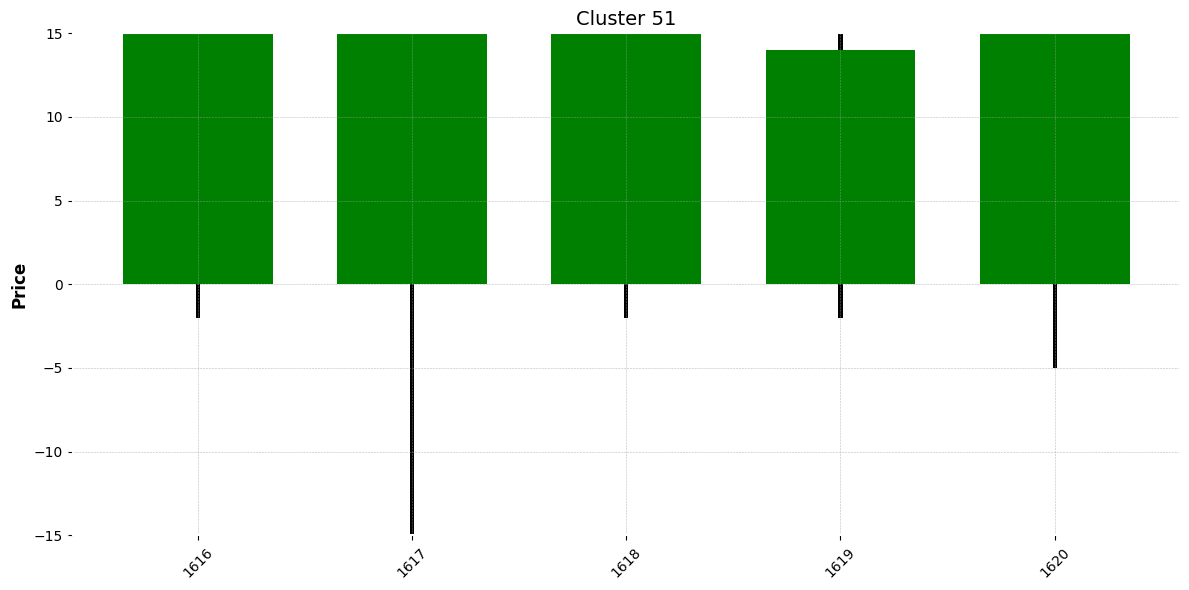

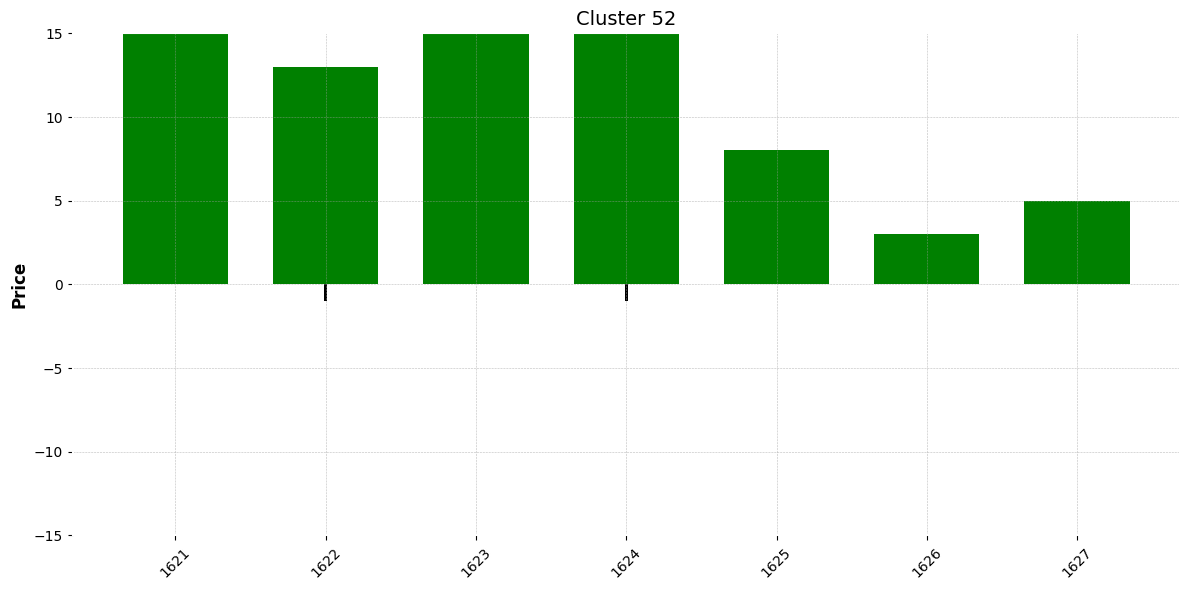

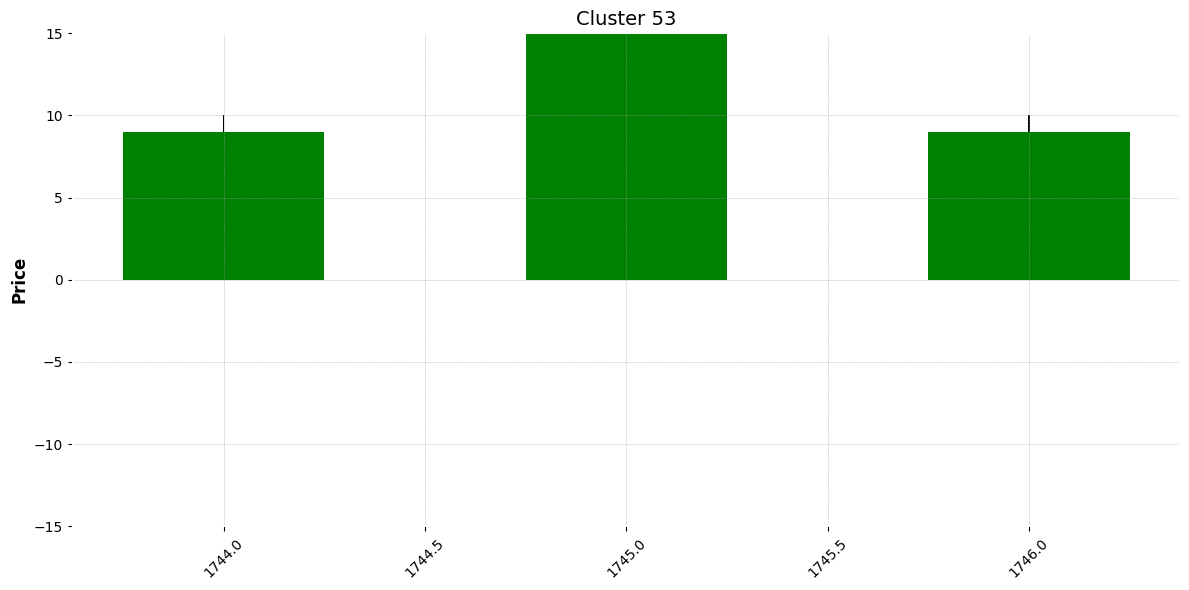

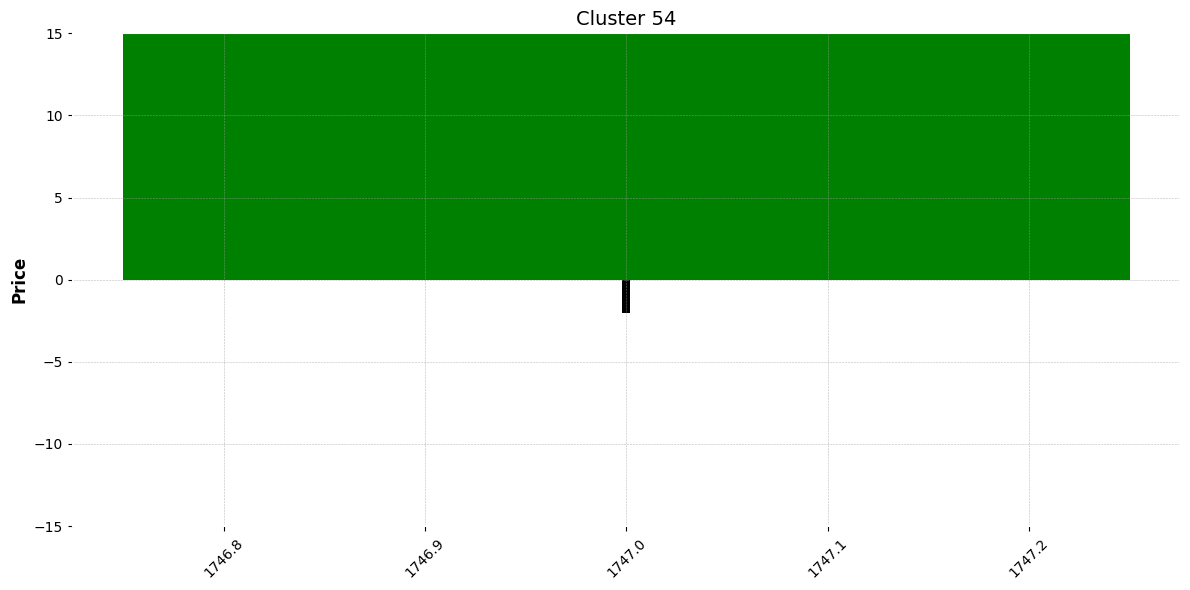

In [162]:
def sorts_data(data, samples_per_cluster=7):
    """Sorts the data by cluster and selects a limited number of samples per cluster."""
    data_sorted = data.sort_values(by='cluster').reset_index(drop=True)
    return data_sorted.groupby('cluster').head(samples_per_cluster)

def plot_clusters(data, cluster_label):
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.grid(True, linestyle='--', alpha=0.7)
    
    candle_width, shadow_width = 0.7, 0.02
    color_up, color_down, color_wick = 'green', 'red', 'black'
    
    if len(data) <= 3:
        candle_width, shadow_width = 0.5, 0.004

    up = data[data['body'] >= 0]
    down = data[data['body'] < 0]
    
    # Plot bullish candles
    ax.bar(up.index, up['body'], candle_width, color=color_up, label='Up')
    ax.bar(up.index, up['upper_shadow'], shadow_width, bottom=up['body'], color=color_wick)
    ax.bar(up.index, up['lower_shadow'], shadow_width, bottom=-up['lower_shadow'], color=color_wick)
    
    # Plot bearish candles
    ax.bar(down.index, -down['body'], candle_width, color=color_down, label='Down')
    ax.bar(down.index, down['upper_shadow'], shadow_width, bottom=-down['body'], color=color_wick)
    ax.bar(down.index, down['lower_shadow'], shadow_width, bottom=-down['lower_shadow'], color=color_wick)
    
    ax.set_ylim(-15, 15)
    ax.set_title(cluster_label, fontsize=14)
    ax.set_ylabel('Price', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

data_limited = sorts_data(data)

samples_per_cluster = [min(count, 7) for count in data.sort_values('cluster')['cluster'].value_counts().sort_index()]
cumulative_samples = list(itertools.accumulate(samples_per_cluster, initial=0))

for i, samples in enumerate(samples_per_cluster):
    start_idx = cumulative_samples[i]
    end_idx = cumulative_samples[i + 1]
    data_cluster = data_limited.iloc[start_idx:end_idx]
    plot_clusters(data_cluster, f'Cluster {i + 1}')

## Reinforcement learning

Para a aplicação do Reinforcement Learning, irei utilizar o Q-learning. A princípio, eu peguei o aquivo "data_with_clusters", que contém os dados com o cluster correspondente cada amostra. Em seguida , defini os parâmetros que irei utilizar

In [163]:
data = pd.read_csv('../outputs/data_with_clusters.csv')
clusters = data['cluster'].unique()
n_clusters = len(clusters)

In [164]:
# Mapear os clusters para estados sequenciais (caso não sejam 0-N)
cluster_to_state = {c: i for i, c in enumerate(sorted(clusters))}
data['state'] = data['cluster'].map(cluster_to_state)

In [165]:
# Actions: 
#   0 = buy, 
#   1 = sell, 
#   2 = hold

actions = [0, 1, 2]
n_actions = len(actions)

# Init Q-table
q_table = np.zeros((n_clusters, n_actions))

# Hiperparâmetros
alpha = 0.1      # taxa de aprendizado
gamma = 0.95     # fator de desconto
epsilon = 0.1    # exploração
n_episodes = 2000

In [ ]:
# Função de recompensa
def get_reward(action, current_close, next_close):
    if action == 0:  # buy
        return next_close - current_close
    elif action == 1:  # sell
        return current_close - next_close
    else:  # hold
        return 0

# Episódios
for episode in range(n_episodes):
    total_reward = 0
    for i in range(len(data) - 1):
        state = data.loc[i, 'state']
        next_state = data.loc[i+1, 'state']
        current_close = data.loc[i, 'Close']
        next_close = data.loc[i+1, 'Close']

        # Escolher ação
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = np.argmax(q_table[state])

        # Calcular recompensa
        reward = get_reward(action, current_close, next_close)
        total_reward += reward

        # Atualizar Q-table
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

    #if episode % 100 == 0:
    print(f'Episódio {episode}: recompensa total = {total_reward}')


Episódio 0: recompensa total = -509.0000
Episódio 1: recompensa total = 365.0000
Episódio 2: recompensa total = 314.0000
Episódio 3: recompensa total = 169.0000
Episódio 4: recompensa total = 625.0000
Episódio 5: recompensa total = 164.0000
Episódio 6: recompensa total = 729.0000
Episódio 7: recompensa total = -163.0000
Episódio 8: recompensa total = 5.0000
Episódio 9: recompensa total = 378.0000
Episódio 10: recompensa total = 531.0000
Episódio 11: recompensa total = 98.0000
Episódio 12: recompensa total = 721.0000
Episódio 13: recompensa total = 841.0000
Episódio 14: recompensa total = 743.0000
Episódio 15: recompensa total = 917.0000
Episódio 16: recompensa total = 823.0000
Episódio 17: recompensa total = 796.0000
Episódio 18: recompensa total = 1028.0000
Episódio 19: recompensa total = 13.0000
Episódio 20: recompensa total = 433.0000
Episódio 21: recompensa total = -90.0000
Episódio 22: recompensa total = -145.0000
Episódio 23: recompensa total = 738.0000
Episódio 24: recompensa to

In [167]:
import pandas as pd
import numpy as np
import random

# Carregar o CSV
df = pd.read_csv('../outputs/data_with_clusters.csv')
clusters = df['cluster'].unique()
n_clusters = len(clusters)

# Mapear os clusters para estados sequenciais (caso não sejam 0-N)
cluster_to_state = {c: i for i, c in enumerate(sorted(clusters))}
df['state'] = df['cluster'].map(cluster_to_state)

# Ações: 0 = comprar, 1 = vender, 2 = segurar
actions = [0, 1, 2]
n_actions = len(actions)

# Inicializar Q-table
q_table = np.zeros((n_clusters, n_actions))

# Hiperparâmetros
alpha = 0.1      # taxa de aprendizado
gamma = 0.95     # fator de desconto
epsilon = 0.1    # exploração
n_episodes = 2000

# Configurações financeiras
initial_cash = 10000

# Função para recompensa baseada em portfólio
def get_reward(prev_value, current_cash, current_shares, current_price):
    new_value = current_cash + current_shares * current_price
    return new_value - prev_value

# Loop de treinamento
for episode in range(n_episodes):
    total_reward = 0
    cash = initial_cash
    shares = 0
    portfolio_value = initial_cash

    for i in range(len(df) - 1):
        state = df.loc[i, 'state']
        next_state = df.loc[i + 1, 'state']
        current_price = df.loc[i, 'Close']
        next_price = df.loc[i + 1, 'Close']

        # Escolher ação (exploração ou exploração)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = np.argmax(q_table[state])

        # Aplicar ação
        if action == 0 and cash >= current_price:  # Comprar
            shares += 1
            cash -= current_price
        elif action == 1 and shares > 0:  # Vender
            shares -= 1
            cash += current_price
        # Segurar não faz nada

        # Calcular recompensa com base no portfólio
        new_portfolio_value = cash + shares * next_price
        reward = new_portfolio_value - portfolio_value
        portfolio_value = new_portfolio_value
        total_reward += reward

        # Atualizar Q-table
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

    if episode % 100 == 0:
        print(f'Episode {episode}: Total Reward = {total_reward:.2f}, Final Cash = {cash:.2f}, Shares = {shares}, Portfolio = {portfolio_value:.2f}')


Episode 0: Total Reward = 691.00, Final Cash = 3047.00, Shares = 2, Portfolio = 10691.00
Episode 100: Total Reward = 430.00, Final Cash = 10430.00, Shares = 0, Portfolio = 10430.00
Episode 200: Total Reward = 747.00, Final Cash = 10747.00, Shares = 0, Portfolio = 10747.00
Episode 300: Total Reward = 1692.00, Final Cash = 11692.00, Shares = 0, Portfolio = 11692.00
Episode 400: Total Reward = -295.00, Final Cash = 9705.00, Shares = 0, Portfolio = 9705.00
Episode 500: Total Reward = 981.00, Final Cash = 10981.00, Shares = 0, Portfolio = 10981.00
Episode 600: Total Reward = 855.00, Final Cash = 10855.00, Shares = 0, Portfolio = 10855.00
Episode 700: Total Reward = 965.00, Final Cash = 10965.00, Shares = 0, Portfolio = 10965.00
Episode 800: Total Reward = 564.00, Final Cash = 10564.00, Shares = 0, Portfolio = 10564.00
Episode 900: Total Reward = 1248.00, Final Cash = 11248.00, Shares = 0, Portfolio = 11248.00
Episode 1000: Total Reward = 316.00, Final Cash = 10316.00, Shares = 0, Portfolio 